In [1]:
import os

working_dir = os.getcwd()w
print(working_dir)

/kaggle/working


In [2]:
!cp -r /kaggle/input/20242-deeplearning/* $working_dir

In [3]:
!pip install -q ultralytics
!pip install $working_dir/LSM-YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
Processing ./LSM-YOLO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.3 MB/s eta 0:00:00
  Created wheel for lsm

In [4]:
# --- Type hints and docstrings were generated by AI and reviewed by the author ngocanhh.---

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tfs
from PIL import Image
import os
from typing import List, Tuple, Dict, Optional, Callable

class CustomDataset(Dataset):
    """
    A custom dataset class for loading images and their corresponding annotations.

    The dataset expects a directory structure where 'data_path' contains
    two subdirectories: 'images' and 'labels'.
    - 'images': Contains image files (e.g., .jpg, .png, .webp).
    - 'labels': Contains annotation files (e.g., .txt) with the same base name
                as their corresponding images. Each line in a label file
                represents an object annotation in the format:
                <class_id> <x_center_norm> <y_center_norm> <width_norm> <height_norm>
    """
    def __init__(self, data_path: str, transforms: Optional[Callable] = None):
        """
        Initializes the CustomDataset.

        Args:
            data_path (str): The root path to the dataset directory.
                             This directory should contain 'images' and 'labels' subfolders.
            transforms (Optional[Callable]): A callable (e.g., torchvision.transforms.Compose)
                                             to apply to the images. Defaults to None.

        Raises:
            FileNotFoundError: If `data_path` does not exist.
        """
        if not os.path.exists(data_path):
            raise FileNotFoundError(f'Path not found {data_path}')
        self.data_path: str = data_path
        self.image_dir: str = os.path.join(self.data_path, 'images')
        self.label_dir: str = os.path.join(self.data_path, 'labels')
        self.transforms: Optional[Callable] = transforms

        # Prepare imgs, labels
        self.images: List[str] = []
        for f in os.listdir(self.image_dir):
            if f.endswith(('.jpg', '.png', '.webp')):
                self.images.append(f)
        self.images.sort()


    def __len__(self) -> int:
        """
        Returns the total number of images in the dataset.

        Returns:
            int: The number of images.
        """
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Retrieves an image and its annotations at the given index.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]:
                - img (torch.Tensor): The transformed image tensor.
                - annotations (torch.Tensor): A tensor of annotations.
                  Each row is [class_id, x_center, y_center, width, height].
                  If no annotations are found, an empty tensor of shape (0, 5)
                  or similar (depending on `torch.tensor(annotations)`) is returned.
                  If annotations exist, its shape is (num_annotations, 5).
        """
        # Get image tensor
        img_path: str = os.path.join(self.image_dir, self.images[idx])
        img: Image.Image = Image.open(img_path).convert('RGB')
        if self.transforms:
            img_tensor: torch.Tensor = self.transforms(img)
        else:
            # If no transforms, convert to tensor manually (basic example)
            img_tensor: torch.Tensor = tfs.ToTensor()(img)


        # Get labels tensor
        label_file_name: str = self.images[idx].split('.')[0] + '.txt'
        label_path: str = os.path.join(self.label_dir, label_file_name)
        annotations_list: List[List[float]] = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines: List[str] = f.readlines()
            for line in lines:
                anno: List[float] = list(map(float, line.split()))
                if len(anno) == 5: # class_id, x_center, y_center, width, height
                    annotations_list.append(anno)

        # Ensure annotations tensor has 2 dimensions, even if empty.
        # If annotations_list is empty, torch.tensor([]) creates a 1D tensor of size 0.
        # We want (0, 5) for consistency if there are no annotations.
        if not annotations_list:
            annotations_tensor: torch.Tensor = torch.empty((0, 5), dtype=torch.float32)
        else:
            annotations_tensor: torch.Tensor = torch.tensor(annotations_list, dtype=torch.float32)

        return img_tensor, annotations_tensor

def custom_collate_fn(data_list: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
    """
    Custom collate function to process a batch of data from CustomDataset.

    It combines images into a single tensor and organizes annotations into a
    dictionary, mapping annotation components (batch_idx, cls, bboxes) to tensors.

    Args:
        data_list (List[Tuple[torch.Tensor, torch.Tensor]]):
            A list of tuples, where each tuple contains:
            - img (torch.Tensor): An image tensor.
            - annotations (torch.Tensor): An annotation tensor of shape (N, 5)
              where N is the number of objects in the image. Each row is
              [class_id, x_center, y_center, width, height].

    Returns:
        Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
            - batch (Dict[str, torch.Tensor]): A dictionary containing:
                - 'img' (torch.Tensor): A tensor of stacked images (B, C, H, W).
                - 'batch_idx' (torch.Tensor): Tensor indicating the image index in the batch
                                              for each bounding box. Shape (total_bboxes,).
                - 'cls' (torch.Tensor): Tensor of class IDs for each bounding box.
                                        Shape (total_bboxes,).
                - 'bboxes' (torch.Tensor): Tensor of bounding boxes (x_center, y_center, width, height)
                                           for all images in the batch. Shape (total_bboxes, 4).
                                           If no bboxes in batch, shape is (0,4).
    """
    imgs: List[torch.Tensor] = []
    batch_index_list: List[int] = []
    cls_list: List[float] = [] # Storing as float initially due to anno[0].item()
    bboxes_list: List[torch.Tensor] = []

    for i, (img, annotations) in enumerate(data_list):
        imgs.append(img)
        # annotations is expected to be (N, 5)
        if annotations.numel() > 0: # Check if annotations tensor is not empty
            for anno in annotations: # anno is a 1D tensor of shape (5,)
                batch_index_list.append(i)
                cls_list.append(anno[0].item()) # class_id
                bboxes_list.append(anno[1:])    # bbox coordinates

    batch: Dict[str, torch.Tensor] = {
        'img': torch.stack(imgs, dim=0),
        'batch_idx': torch.tensor(batch_index_list, dtype=torch.int64),
        'cls': torch.tensor(cls_list, dtype=torch.int64), # Convert class IDs to int64
        'bboxes': torch.empty((0, 4), dtype=torch.float32) if not bboxes_list else torch.stack(bboxes_list, dim=0)
    }

    return batch

def get_dataloader(data_path: str,
                   batch_size: int = 4,
                   num_workers: int = 4,
                   shuffle: bool = True) -> DataLoader:
    """
    Creates and returns a DataLoader for the CustomDataset.

    Args:
        data_path (str): Path to the dataset.
        batch_size (int): Number of samples per batch. Defaults to 4.
        num_workers (int): Number of subprocesses to use for data loading.
                           Defaults to 4.
        pin_memory (bool): If True, the data loader will copy Tensors
                           into CUDA pinned memory before returning them.
                           Defaults to True.
        shuffle (bool): Whether to shuffle the data at every epoch. Defaults to True.


    Returns:
        DataLoader: A PyTorch DataLoader instance.
    """
    transforms: tfs.Compose = tfs.Compose([
        tfs.Resize((640, 640)),
        tfs.ToTensor()
    ])
    dataset: CustomDataset = CustomDataset(data_path, transforms)

    return DataLoader(dataset,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      pin_memory=False,
                      shuffle=shuffle,
                      collate_fn=custom_collate_fn)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from ultralytics import YOLO as YOLO_ultra
from lsmyolo import YOLO as YOLO_lsm
import math
import copy

class KDModelConfig:
    def __init__(self):
        self.layers_name = ['head_p3', 'head_p4', 'head_p5', 'backbone_p3', 'backbone_p4', 'backbone_p5']
        self.student_layers_idx = {
            'head_p3': 21,
            'head_p4': 24,
            'head_p5': 27,
            'backbone_p3': 4,
            'backbone_p4': 6,
            'backbone_p5': 9
        }
        self.teacher_layers_idx = {
            'head_p3': 15,
            'head_p4': 18,
            'head_p5': 21,
            'backbone_p3': 4,
            'backbone_p4': 6,
            'backbone_p5': 9
        }
        self.student_layers_output_channel = {
            'head_p3': 64,
            'head_p4': 128,
            'head_p5': 256,
            'backbone_p3': 64,
            'backbone_p4': 128,
            'backbone_p5': 256
        }
        self.teacher_layers_output_channel = {
            'head_p3': 256,
            'head_p4': 512,
            'head_p5': 512,
            'backbone_p3': 512,
            'backbone_p4': 512,
            'backbone_p5': 512
        }

    @classmethod
    def from_dict(cls, config_dict):
        """
        Create a KDModelConfig instance from a dictionary

        Args:
            config_dict (dict): Dictionary containing configuration parameters

        Returns:
            KDModelConfig: A new instance with parameters from the dictionary
        """
        config = cls()

        # Update config with values from dictionary
        if 'layers_name' in config_dict:
            config.layers_name = config_dict['layers_name']

        if 'student_layers_idx' in config_dict:
            config.student_layers_idx = config_dict['student_layers_idx']

        if 'teacher_layers_idx' in config_dict:
            config.teacher_layers_idx = config_dict['teacher_layers_idx']

        if 'student_layers_output_channel' in config_dict:
            config.student_layers_output_channel = config_dict['student_layers_output_channel']

        if 'teacher_layers_output_channel' in config_dict:
            config.teacher_layers_output_channel = config_dict['teacher_layers_output_channel']

        return config

class FeatureExtractor():
    def __init__(self):
        self.features = {}

    def get_hook(self, name):

        def hook(module, input, output):
            self.features[name] = output
            # print(module.__class__.__name__)
            # print(output.shape)

        return hook

    def clear(self):
        self.features.clear()

class HyperParams:
    def __init__(self, hyp_dict):
        # Set default values
        self.box = 7.5  # Default YOLOv8 values
        self.cls = 0.5
        self.dfl = 1.5

        # Update with any values from the dict
        for key, value in hyp_dict.items():
            setattr(self, key, value)

        # Ensure the hyp attribute exists
        if not hasattr(self, 'hyp'):
            self.hyp = self

class Teacher(nn.Module):
    def __init__(self, model, config):
        super(Teacher, self).__init__()

        # Get base model
        yolo = YOLO_ultra(model)
        self.model = yolo.model
        self.config = config

        # Feature extractor and register hooks
        self.feature_extractor = FeatureExtractor()
        for layer_name in self.config.layers_name:
            layer = self.model.model[self.config.teacher_layers_idx[layer_name]]
            layer.register_forward_hook(self.feature_extractor.get_hook(layer_name))

        # Get hyperparams
        self.model.args = HyperParams(self.model.args)

        # Get number of classes
        self.nc = self.model.model[-1].nc

    def forward(self, x):
        self.feature_extractor.clear()
        x = self.model(x)

        return x, self.feature_extractor.features

class Student(nn.Module):
    def __init__(self, model, config):
        super(Student, self).__init__()

        # Get base model
        self.yolo = YOLO_lsm(model)
        self.model = self.yolo.model
        self.config = config

        # Feature extractor and register hooks
        self.feature_extractor = FeatureExtractor()
        for layer_name in self.config.layers_name:
            layer = self.model.model[self.config.student_layers_idx[layer_name]]
            layer.register_forward_hook(self.feature_extractor.get_hook(layer_name))

        # Get hyperparams
        self.model.args = HyperParams(self.model.args)

        # Get number of classes
        self.nc = self.model.model[-1].nc

    def eval(self):
        self.training = False
        self.model.eval()

    def train(self):
        self.training = True
        self.model.train()

    def forward(self, x):
        self.feature_extractor.clear()
        x = self.model(x)

        return x, self.feature_extractor.features

class KD_Model(nn.Module):
    def __init__(self, teacher_model, student_model, config=None):
        super(KD_Model, self).__init__()
        self.config = config if config is not None else KDModelConfig()
        self.teacher = Teacher(teacher_model, self.config)
        self.student = Student(student_model, self.config)

        # Get number of classes
        self.nc = self.student.nc
        self.adapters = nn.ModuleDict()

        for layer_name in self.config.layers_name:
            adapter = nn.Conv2d(
                self.config.student_layers_output_channel[layer_name],
                self.config.teacher_layers_output_channel[layer_name],
                kernel_size=1,
                stride=1,
                padding=0
            )

            nn.init.kaiming_normal_(adapter.weight, a=math.sqrt(5))
            if adapter.bias is not None:
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(adapter.weight)
                if fan_in != 0: # Tránh chia cho 0
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(adapter.bias, -bound, bound)
                else:
                    nn.init.constant_(adapter.bias, 0) # Fallback

            self.adapters[layer_name] = adapter


    def eval(self):
        # super(KD_Model, self).eval()
        self.training = False
        self.student.eval()
        self.teacher.eval()
        self.adapters.eval()

    def train(self):
        # super(KD_Model, self).train()
        self.training = True
        self.student.train()
        self.adapters.train()
        self.teacher.eval()

    def val(self, data_yaml_path, project, name, split='val', save=True):
        yolo_to_val = copy.deepcopy(self.student.yolo)
        metrics = yolo_to_val.val(
            data=data_yaml_path,
            split=split,
            save_json=False,
            project=project,
            name=name,
            save=save, 
        )
        return metrics

    def forward(self, x):
        with torch.no_grad():
            _, teacher_features = self.teacher(x)

        student_output, original_student_features = self.student(x)

        adapted_student_features = {}
        for layer_name in self.config.layers_name:
            adapted_student_features[layer_name] = self.adapters[layer_name](original_student_features[layer_name])
            # print(student_features[layer_name].shape)
        return student_output, adapted_student_features, teacher_features

    def get_distillation_loss(self, adapted_student_features, teacher_features):
        loss = 0
        for layer_name in self.config.layers_name:
            loss += F.mse_loss(adapted_student_features[layer_name], teacher_features[layer_name])
        return loss

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
v9c_to_lsm = {
    'layers_name': ['head_p3', 'head_p4', 'head_p5', 'backbone_p3', 'backbone_p4', 'backbone_p5'],
    'student_layers_idx': {
            'head_p3': 21,
            'head_p4': 24,
            'head_p5': 27,
            'backbone_p3': 4,
            'backbone_p4': 6,
            'backbone_p5': 9
    },
    'teacher_layers_idx': {
            'head_p3': 15,
            'head_p4': 18,
            'head_p5': 21,
            'backbone_p3': 4,
            'backbone_p4': 6,
            'backbone_p5': 9
    },
    'student_layers_output_channel': {
            'head_p3': 64,
            'head_p4': 128,
            'head_p5': 256,
            'backbone_p3': 64,
            'backbone_p4': 128,
            'backbone_p5': 256
    },
    'teacher_layers_output_channel': {
            'head_p3': 256,
            'head_p4': 512,
            'head_p5': 512,
            'backbone_p3': 512,
            'backbone_p4': 512,
            'backbone_p5': 512
    }
}

v8s_to_lsm = {
    'layers_name': ['head_p3', 'head_p4', 'head_p5', 'backbone_p3', 'backbone_p4', 'backbone_p5'],
    'student_layers_idx': {
            'head_p3': 21,
            'head_p4': 24,
            'head_p5': 27,
            'backbone_p3': 4,
            'backbone_p4': 6,
            'backbone_p5': 9
    },
    'teacher_layers_idx': {
            'head_p3': 15,
            'head_p4': 18,
            'head_p5': 21,
            'backbone_p3': 4,
            'backbone_p4': 6,
            'backbone_p5': 9
    },
    'student_layers_output_channel': {
            'head_p3': 64,
            'head_p4': 128,
            'head_p5': 256,
            'backbone_p3': 64,
            'backbone_p4': 128,
            'backbone_p5': 256
    },
    'teacher_layers_output_channel': {
            'head_p3': 128,
            'head_p4': 256,
            'head_p5': 512,
            'backbone_p3': 128,
            'backbone_p4': 256,
            'backbone_p5': 512
    }
}

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
from lsmyolo.utils.loss import v8DetectionLoss

def evaluate(kd_model, val_dataloader, student_loss_fn, device, lambda_kd, epoch_num=-1, num_epochs=-1):
    kd_model.eval()  # Đặt model ở chế độ evaluation
    total_val_loss_epoch = 0
    main_val_loss_epoch = 0
    kd_val_loss_epoch = 0

    # Tắt tính toán gradient cho quá trình evaluation
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(val_dataloader):
            # Di chuyển dữ liệu sang device
            for key in batch_data:
                if isinstance(batch_data[key], torch.Tensor):
                    batch_data[key] = batch_data[key].to(device)

            images = batch_data['img']

            # 1. Forward pass
            # Giả định kd_model.forward() trả về (student_raw_output, student_features_adapted, teacher_features)
            # ngay cả trong chế độ eval. Nếu teacher_features không có sẵn, nó nên là None.
            student_raw_output_for_loss_fn, student_features_adapted, teacher_features = kd_model(images)

            # 2. Tính main loss (hiệu suất của student)
            main_loss_total, main_loss_components = student_loss_fn(student_raw_output_for_loss_fn, batch_data)
            main_loss = main_loss_total / images.shape[0]  # Chuẩn hóa theo batch size

            # 3. Tính distillation loss
            distillation_loss = kd_model.get_distillation_loss(student_features_adapted, teacher_features)

            # 4. Kết hợp loss
            combined_loss = main_loss + lambda_kd * distillation_loss

            # 5. Cộng dồn loss
            total_val_loss_epoch += combined_loss.item()
            main_val_loss_epoch += main_loss.item()
            kd_val_loss_epoch += distillation_loss.item()

            # if batch_idx % 10 == 0:  # In log mỗi 10 batch cho validation
            #     box_l, cls_l, dfl_l = main_loss_components
            #     epoch_str = f"Epoch {epoch_num+1}/{num_epochs} | " if epoch_num != -1 else ""
            #     print(f"{epoch_str}Validation Batch {batch_idx}/{len(val_dataloader)} | "
            #           f"Total Val Loss: {combined_loss.item():.4f} | "
            #           f"Main Val Loss: {main_loss.item():.4f} (Box: {box_l.item():.4f}, "
            #           f"Cls: {cls_l.item():.4f}, DFL: {dfl_l.item():.4f}) | "
            #           f"KD Val Loss: {distillation_loss.item():.4f}")

    avg_total_val_loss = total_val_loss_epoch / len(val_dataloader)
    avg_main_val_loss = main_val_loss_epoch / len(val_dataloader)
    avg_kd_val_loss = kd_val_loss_epoch / len(val_dataloader)

    # epoch_str_summary = f"Epoch {epoch_num+1} " if epoch_num != -1 else ""
    # print(f"--- {epoch_str_summary}Validation Summary ---")
    # print(f"Avg Total Validation Loss: {avg_total_val_loss:.4f}")
    # print(f"Avg Main Validation Loss: {avg_main_val_loss:.4f}")
    # print(f"Avg KD Validation Loss: {avg_kd_val_loss:.4f}")

    return avg_total_val_loss, avg_main_val_loss, avg_kd_val_loss



def train_one_epoch(kd_model, student_loss_fn, optimizer, dataloader, device, lambda_kd, epoch_num, num_epochs):
    kd_model.train()
    total_loss_epoch = 0
    main_loss_epoch = 0
    kd_loss_epoch = 0

    for batch_idx, batch_data in enumerate(dataloader):
        # Move data to device
        for key in batch_data:
            if isinstance(batch_data[key], torch.Tensor):
                batch_data[key] = batch_data[key].to(device)

        # 1. Forward pass
        images = batch_data['img']
        optimizer.zero_grad()

        student_raw_output_for_loss_fn, student_features_adapted, teacher_features = kd_model(images)

        # 2. Calculate main loss
        main_loss_total, main_loss_components = student_loss_fn(student_raw_output_for_loss_fn, batch_data)
        # Main loss is calculated with hyp gains (box, cls, dfl), components are detached and not scaled by hyp
        main_loss = main_loss_total / images.shape[0] # Normalize by batch size

        # 3. Calculate distillation loss
        distillation_loss = kd_model.get_distillation_loss(student_features_adapted, teacher_features)

        # 4. Combine loss
        combined_loss = main_loss + lambda_kd * distillation_loss

        # 5. Backward pass
        combined_loss.backward()

        # 6. Update parameters
        optimizer.step()

        # 7. Log loss
        total_loss_epoch += combined_loss.item()
        main_loss_epoch += main_loss.item()
        kd_loss_epoch += distillation_loss.item()

        if batch_idx % 10 == 0:
            box_l, cls_l, dfl_l = main_loss_components
            # print(f"Epoch {epoch_num+1}/{num_epochs} | Batch {batch_idx}/{len(dataloader)} | "
            #       f"Total Loss: {combined_loss.item():.4f} | "
            #       f"Main Loss (avg): {main_loss.item():.4f} (Box: {box_l.item():.4f}, "
            #       f"Cls: {cls_l.item():.4f}, DFL: {dfl_l.item():.4f}) | "
            #       f"KD Loss: {distillation_loss.item():.4f}")

    avg_total_loss = total_loss_epoch / len(dataloader)
    avg_main_loss = main_loss_epoch / len(dataloader)
    avg_kd_loss = kd_loss_epoch / len(dataloader)
    # print(f"--- Epoch {epoch_num+1} Summary ---")
    # print(f"Avg Total Loss: {avg_total_loss:.4f}")
    # print(f"Avg Main Loss: {avg_main_loss:.4f}")
    # print(f"Avg KD Loss: {avg_kd_loss:.4f}")
    return avg_total_loss, avg_main_loss, avg_kd_loss

In [8]:
# 1. Set device
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# 2. Setup model
model_name = 'yolov8n_best.pt'
teacher_model_path = os.path.join(working_dir, 'pretrained_model', model_name)
student_model_cfg_path = 'LSM-YOLO/LSM-YOLO.yaml'
config = KDModelConfig.from_dict(v8s_to_lsm)
kd_model = KD_Model(teacher_model_path, student_model_cfg_path, config)

# # 2.1. Check multi-gpu
# if torch.cuda.device_count() > 1 and device == torch.device('cuda'):
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     kd_model = torch.nn.DataParallel(kd_model)

kd_model.to(device)

# 3. Setup loss fn
try:
    # v8DetectionLoss need an instance of ultralytics.nn.tasks.DectectionModel as parameter
    student_loss_fn = v8DetectionLoss(kd_model.student.model)
    print("Successfully initialized v8DetectionLoss for student model.")
except Exception as e:
    print(f"Error initializing student_loss_fn (v8DetectionLoss): {e}")
    print("Please ensure that:")
    print("1. `kd_model.student.model` is the correct LSM-YOLO model object (e.g., instance of DetectionModel).")
    print("2. The student model has a `model[-1]` (Detect layer) with `stride`, `nc`, `reg_max` attributes.")
    print("3. The student model has an `args` attribute (or `hyp`) containing hyperparameters like `box`, `cls`, `dfl` gains.")
    import traceback
    traceback.print_exc()

# 4. Setup optimizer
student_model_to_optimize = kd_model.student.model

# Hyperparameters cho AdamW theo kiểu Ultralytics (giá trị mặc định/phổ biến)
lr = 0.001
beta1 = 0.9
beta2 = 0.999
default_weight_decay = 1e-5 # Sẽ áp dụng cho nhóm g0

print(f"Building AdamW optimizer for student model: {type(student_model_to_optimize).__name__}")

g0, g1, g2 = [], [], []  # optimizer parameter groups
bn = tuple(v for k, v in nn.__dict__.items() if "Norm" in k)  # normalization layers

for module_name, module in student_model_to_optimize.named_modules():
    for param_name, param in module.named_parameters(recurse=False):
        if not param.requires_grad:
            continue
        fullname = f"{module_name}.{param_name}" if module_name else param_name
        if "bias" in fullname:
            g2.append(param)  # Biases
        elif isinstance(module, bn) or "logit_scale" in fullname:
            g1.append(param)  # BatchNorm weights, logit_scale
        else:
            g0.append(param)  # Other weights

# Khởi tạo AdamW
# Nhóm g2 (biases) được truyền vào constructor với weight_decay=0.0
optimizer = optim.AdamW(g2, lr=lr, betas=(beta1, beta2), weight_decay=0.0)

# Thêm nhóm g0 (weights chính) với weight_decay đã định nghĩa
optimizer.add_param_group({"params": g0, "weight_decay": default_weight_decay})

# Thêm nhóm g1 (BatchNorm weights, etc.) với weight_decay=0.0
optimizer.add_param_group({"params": g1, "weight_decay": 0.0})

print(
    f"Optimizer: AdamW(lr={lr}, betas=({beta1},{beta2})) with parameter groups:\n"
    f"  - Group 0 (Main Weights): {len(g0)} params, weight_decay={default_weight_decay}\n"
    f"  - Group 1 (BN Weights/logit_scale): {len(g1)} params, weight_decay=0.0\n"
    f"  - Group 2 (Biases): {len(g2)} params, weight_decay=0.0"
)

# Thêm tham số của adapters vào optimizer
if hasattr(kd_model, 'adapters') and list(kd_model.adapters.parameters()):
    adapter_params = list(kd_model.adapters.parameters())
    if adapter_params:
        print(f"Adding adapter parameters to the AdamW optimizer.")
        adapter_weight_decay = default_weight_decay 
        adapter_lr = lr
        optimizer.add_param_group({
            "params": adapter_params,
            "weight_decay": adapter_weight_decay,
            "lr": adapter_lr,
            "name": "adapters" 
        })
        print(f"  - Group Adapters: {len(adapter_params)} params, weight_decay={adapter_weight_decay}, lr={adapter_lr}")
    else:
        print("No trainable parameters found in kd_model.adapters.")
else:
    print("kd_model.adapters not found or has no parameters.")

# params_to_optimize = [
#     {'params': kd_model.student.parameters()},
#     {'params': kd_model.adapters.parameters()},
# ]
# optimizer = optim.AdamW(params_to_optimize, lr=5e-4)

# 5. Set dataloader
data_dir = os.path.join(working_dir, 'Br35H-Mask-Prepared')
train_data_dir = os.path.join(data_dir, 'train')
val_data_dir = os.path.join(data_dir, 'val')
data_yaml_path = os.path.join(data_dir, 'data.yaml')
batch_size = 16
num_workers = 2
train_dataloader = get_dataloader(train_data_dir, batch_size, num_workers)
val_dataloader = get_dataloader(val_data_dir, batch_size, num_workers)

Using device: cuda


WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       788  lsmyolo.nn.modules.RFAConv.RFAConv           [3, 16, 3, 2]                 
  1                  -1  1      6400  lsmyolo.nn.modules.RFAConv.RFAConv           [16, 32, 3, 2]                
  2                  -1  1      8736  lsmyolo.nn.modules.block.MSFM                [32, 32, 1, True]             
  3                  -1  1     19776  lsmyolo.nn.modules.block.LAE                 [32]                          
  4                  -1  2     58240  lsmyolo.nn.modules.block.MSFM                [32, 64, 2, True]             
  5                  -1  1     41600  lsmyolo.nn.modules.block.LAE                 [64]                          
  6                  -1  2    231168  lsmyolo.nn.modules.block.MSFM                [64, 128, 2, True]            
  7                  -1  1     91

Successfully initialized v8DetectionLoss for student model.
Building AdamW optimizer for student model: DetectionModel
Optimizer: AdamW(lr=0.001, betas=(0.9,0.999)) with parameter groups:
  - Group 0 (Main Weights): 124 params, weight_decay=1e-05
  - Group 1 (BN Weights/logit_scale): 114 params, weight_decay=0.0
  - Group 2 (Biases): 122 params, weight_decay=0.0
Adding adapter parameters to the AdamW optimizer.
  - Group Adapters: 12 params, weight_decay=1e-05, lr=0.001


In [9]:
# 6. Training loop
num_epochs = 300
lambda_kd = 3 # distillation loss weight

best_map = 0
maps = []
train_avg_losses = []
train_main_losses = []
train_kd_losses = []
val_avg_losses = []
val_main_losses = []
val_kd_losses = []

print(f'***** START TRAINING WITH {num_epochs} EPOCHS, KD {model_name}, LAMBDA_KD {lambda_kd}')
for epoch in range(num_epochs):
    print('-' * 20 + f' EPOCH {epoch+1} START ' + '-' * 20)
    # TRAIN
    print('Training start ...')
    train_avg_loss, train_main_loss, train_kd_loss = train_one_epoch(
        kd_model, student_loss_fn, optimizer, train_dataloader, device, lambda_kd, epoch, num_epochs
    )
    print(f'TRAIN:\n\tAVG_LOSS: {train_avg_loss}\n\tMAIN_LOSS: {train_main_loss}\n\tKD_LOSS: {train_kd_loss}')
    train_avg_losses.append(train_avg_loss)
    train_main_losses.append(train_main_loss)
    train_kd_losses.append(train_kd_loss)

    # EVALUATE
    print('Evaluating start ...')
    val_avg_loss, val_main_loss, val_kd_loss = evaluate(
        kd_model, val_dataloader, student_loss_fn, device, lambda_kd, epoch, num_epochs
    )
    print(f'VAL:\n\tAVG_LOSS: {val_avg_loss}\n\tMAIN_LOSS: {val_main_loss}\n\tKD_LOSS: {val_kd_loss}')
    val_avg_losses.append(val_avg_loss)
    val_main_losses.append(val_main_loss)
    val_kd_losses.append(val_kd_loss)

    with torch.no_grad():
        metrics = kd_model.val('/kaggle/working/Br35H-Mask-Prepared/data.yaml', split='val', project='runs', name='epoch', save=False)

    maps.append(metrics.box.map)

    if best_map <= metrics.box.map:
        best_map = metrics.box.map
        torch.save(kd_model.student.model.state_dict(), 'lsm_best.pt')
        print(f"Epoch {epoch+1}: New best mAP: {best_map:.4f}, model saved.")
    print('-' * 20 + f' EPOCH {epoch+1} END ' + '-' * 20)
    
torch.save(kd_model.student.model.state_dict(), 'lsm_last.pt')
    
print("Training finished.")

***** START TRAINING WITH 300 EPOCHS, KD yolov8n_best.pt, LAMBDA_KD 3
-------------------- EPOCH 1 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 15.59426754335814
	MAIN_LOSS: 12.899992037423049
	KD_LOSS: 0.898091854928415
Evaluating start ...
VAL:
	AVG_LOSS: 15.241217295328775
	MAIN_LOSS: 13.095138708750406
	KD_LOSS: 0.7153595263759295


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<00:00, 2000.15it/s]
val: New cache created: /kaggle/working/Br35H-Mask-Prepared/val/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]
                   all        376        181   0.000589      0.287   0.000536    0.00016
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 17.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/epoch


Epoch 1: New best mAP: 0.0002, model saved.
-------------------- EPOCH 1 END --------------------
-------------------- EPOCH 2 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 12.316650125044811
	MAIN_LOSS: 10.420361180848714
	KD_LOSS: 0.6320963154865217
Evaluating start ...
VAL:
	AVG_LOSS: 12.491517265637716
	MAIN_LOSS: 10.442134221394857
	KD_LOSS: 0.6831276789307594


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]
                   all        376        181    0.00151      0.492     0.0162    0.00478
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/epoch2


Epoch 2: New best mAP: 0.0048, model saved.
-------------------- EPOCH 2 END --------------------
-------------------- EPOCH 3 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 11.107416744473614
	MAIN_LOSS: 9.390781571593466
	KD_LOSS: 0.5722117307065409
Evaluating start ...
VAL:
	AVG_LOSS: 11.326274593671164
	MAIN_LOSS: 9.599076867103577
	KD_LOSS: 0.5757325937350591


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181    0.00226      0.536     0.0941     0.0289
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/epoch3


Epoch 3: New best mAP: 0.0289, model saved.
-------------------- EPOCH 3 END --------------------
-------------------- EPOCH 4 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 10.590548515319824
	MAIN_LOSS: 8.98556633237042
	KD_LOSS: 0.5349940755699254
Evaluating start ...
VAL:
	AVG_LOSS: 11.645959973335266
	MAIN_LOSS: 9.654433727264404
	KD_LOSS: 0.6638420969247818


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]
                   all        376        181     0.0867      0.182      0.049     0.0161
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/epoch4


-------------------- EPOCH 4 END --------------------
-------------------- EPOCH 5 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 9.861418687844578
	MAIN_LOSS: 8.338327462160134
	KD_LOSS: 0.5076970808868166
Evaluating start ...
VAL:
	AVG_LOSS: 13.788251399993896
	MAIN_LOSS: 11.909088015556335
	KD_LOSS: 0.6263877662519614


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181     0.0816      0.232       0.04     0.0135
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/epoch5


-------------------- EPOCH 5 END --------------------
-------------------- EPOCH 6 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 9.29403861564926
	MAIN_LOSS: 7.811424738244165
	KD_LOSS: 0.4942046302028849
Evaluating start ...
VAL:
	AVG_LOSS: 9.395620544751486
	MAIN_LOSS: 7.884124477704366
	KD_LOSS: 0.5038319776455561


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.447      0.343      0.342      0.109
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch6


Epoch 6: New best mAP: 0.1095, model saved.
-------------------- EPOCH 6 END --------------------
-------------------- EPOCH 7 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 9.016200192366973
	MAIN_LOSS: 7.562074981158292
	KD_LOSS: 0.48470840423921996
Evaluating start ...
VAL:
	AVG_LOSS: 9.078683455785116
	MAIN_LOSS: 7.4986625512441
	KD_LOSS: 0.5266736211876074


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.523      0.431      0.401      0.149
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch7


Epoch 7: New best mAP: 0.1485, model saved.
-------------------- EPOCH 7 END --------------------
-------------------- EPOCH 8 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 8.29080240032341
	MAIN_LOSS: 6.885422374628767
	KD_LOSS: 0.4684599947325791
Evaluating start ...
VAL:
	AVG_LOSS: 8.65201630194982
	MAIN_LOSS: 7.205700000127156
	KD_LOSS: 0.48210544635852176


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.469      0.474      0.391      0.147
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch8


-------------------- EPOCH 8 END --------------------
-------------------- EPOCH 9 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 7.555525200276435
	MAIN_LOSS: 6.191751860365083
	KD_LOSS: 0.4545911128007913
Evaluating start ...
VAL:
	AVG_LOSS: 8.084715982278189
	MAIN_LOSS: 6.666765034198761
	KD_LOSS: 0.47265032306313515


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.692      0.503       0.56      0.269
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch9


Epoch 9: New best mAP: 0.2693, model saved.
-------------------- EPOCH 9 END --------------------
-------------------- EPOCH 10 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 7.161391330670707
	MAIN_LOSS: 5.825187248519704
	KD_LOSS: 0.44540135430384287
Evaluating start ...
VAL:
	AVG_LOSS: 7.395600577195485
	MAIN_LOSS: 6.010024785995483
	KD_LOSS: 0.4618585954109828


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.632      0.456      0.514      0.253
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch10


-------------------- EPOCH 10 END --------------------
-------------------- EPOCH 11 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 6.238925161240976
	MAIN_LOSS: 4.942924831486955
	KD_LOSS: 0.43200011004375505
Evaluating start ...
VAL:
	AVG_LOSS: 6.742232342561086
	MAIN_LOSS: 5.461742242177327
	KD_LOSS: 0.42683002228538197


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.713      0.618      0.661      0.373
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch11


Epoch 11: New best mAP: 0.3730, model saved.
-------------------- EPOCH 11 END --------------------
-------------------- EPOCH 12 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 5.7186022287682645
	MAIN_LOSS: 4.449458188648466
	KD_LOSS: 0.4230480201636689
Evaluating start ...
VAL:
	AVG_LOSS: 6.695407609144847
	MAIN_LOSS: 5.377615948518117
	KD_LOSS: 0.43926388397812843


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.657      0.536      0.618      0.348
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch12


-------------------- EPOCH 12 END --------------------
-------------------- EPOCH 13 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 5.458320768573616
	MAIN_LOSS: 4.208160804796822
	KD_LOSS: 0.41671998666811594
Evaluating start ...
VAL:
	AVG_LOSS: 6.33990091085434
	MAIN_LOSS: 5.0194153388341265
	KD_LOSS: 0.4401618614792824


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.728      0.552      0.612      0.376
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch13


Epoch 13: New best mAP: 0.3758, model saved.
-------------------- EPOCH 13 END --------------------
-------------------- EPOCH 14 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 5.033833425256271
	MAIN_LOSS: 3.8131538010850736
	KD_LOSS: 0.4068932080570656
Evaluating start ...
VAL:
	AVG_LOSS: 5.973801612854004
	MAIN_LOSS: 4.694401403268178
	KD_LOSS: 0.42646673570076626


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.867      0.685      0.761      0.454
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch14


Epoch 14: New best mAP: 0.4537, model saved.
-------------------- EPOCH 14 END --------------------
-------------------- EPOCH 15 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 4.923166631143304
	MAIN_LOSS: 3.7206191292291955
	KD_LOSS: 0.4008491688136813
Evaluating start ...
VAL:
	AVG_LOSS: 5.923094809055328
	MAIN_LOSS: 4.704565405845642
	KD_LOSS: 0.40617647518714267


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.924      0.669      0.776      0.455
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch15


Epoch 15: New best mAP: 0.4549, model saved.
-------------------- EPOCH 15 END --------------------
-------------------- EPOCH 16 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 4.706483255458783
	MAIN_LOSS: 3.5075226554387733
	KD_LOSS: 0.3996535335914998
Evaluating start ...
VAL:
	AVG_LOSS: 5.8976032336552935
	MAIN_LOSS: 4.6589013040065765
	KD_LOSS: 0.4129006552199523


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.879      0.684      0.759      0.472
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch16


Epoch 16: New best mAP: 0.4718, model saved.
-------------------- EPOCH 16 END --------------------
-------------------- EPOCH 17 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 4.232370889639553
	MAIN_LOSS: 3.0803569872168044
	KD_LOSS: 0.38400463854210287
Evaluating start ...
VAL:
	AVG_LOSS: 6.1217966477076216
	MAIN_LOSS: 4.925103187561035
	KD_LOSS: 0.39889781425396603


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.811      0.641       0.74      0.451
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch17


-------------------- EPOCH 17 END --------------------
-------------------- EPOCH 18 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 4.272451947006998
	MAIN_LOSS: 3.1175387282914753
	KD_LOSS: 0.38497107919258405
Evaluating start ...
VAL:
	AVG_LOSS: 7.4446737964948015
	MAIN_LOSS: 5.954111615816752
	KD_LOSS: 0.4968540407717228


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.483      0.541      0.495      0.233
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch18


-------------------- EPOCH 18 END --------------------
-------------------- EPOCH 19 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 4.688473016400881
	MAIN_LOSS: 3.4693601010720942
	KD_LOSS: 0.4063709597044353
Evaluating start ...
VAL:
	AVG_LOSS: 5.7259518802165985
	MAIN_LOSS: 4.479633043209712
	KD_LOSS: 0.4154396007458369


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.861      0.729      0.783      0.475
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch19


Epoch 19: New best mAP: 0.4746, model saved.
-------------------- EPOCH 19 END --------------------
-------------------- EPOCH 20 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 4.138295747056792
	MAIN_LOSS: 2.99291081066373
	KD_LOSS: 0.3817949864683272
Evaluating start ...
VAL:
	AVG_LOSS: 5.3004118005434675
	MAIN_LOSS: 4.144979437192281
	KD_LOSS: 0.38514412691195804


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.851       0.74      0.791      0.502
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch20


Epoch 20: New best mAP: 0.5022, model saved.
-------------------- EPOCH 20 END --------------------
-------------------- EPOCH 21 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 3.95783841459057
	MAIN_LOSS: 2.8455539308016813
	KD_LOSS: 0.37076149069810216
Evaluating start ...
VAL:
	AVG_LOSS: 5.174184739589691
	MAIN_LOSS: 4.037536422411601
	KD_LOSS: 0.3788827570776145


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.865      0.724       0.79      0.521
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch21


Epoch 21: New best mAP: 0.5209, model saved.
-------------------- EPOCH 21 END --------------------
-------------------- EPOCH 22 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 3.760465006285076
	MAIN_LOSS: 2.6665523293652114
	KD_LOSS: 0.3646375627457341
Evaluating start ...
VAL:
	AVG_LOSS: 5.0773466030756635
	MAIN_LOSS: 3.972451408704122
	KD_LOSS: 0.3682983952263991


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.839      0.775      0.809      0.529
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch22


Epoch 22: New best mAP: 0.5288, model saved.
-------------------- EPOCH 22 END --------------------
-------------------- EPOCH 23 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 3.623008124436004
	MAIN_LOSS: 2.5445538050011742
	KD_LOSS: 0.3594847717617132
Evaluating start ...
VAL:
	AVG_LOSS: 5.178357909123103
	MAIN_LOSS: 4.08194042245547
	KD_LOSS: 0.3654725005229314


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.894      0.742       0.82      0.512
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch23


-------------------- EPOCH 23 END --------------------
-------------------- EPOCH 24 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 3.621293985390965
	MAIN_LOSS: 2.5502849258954012
	KD_LOSS: 0.3570030165624015
Evaluating start ...
VAL:
	AVG_LOSS: 5.024024625619252
	MAIN_LOSS: 3.9400611023108163
	KD_LOSS: 0.3613211587071419


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181       0.88      0.702      0.807      0.518
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch24


-------------------- EPOCH 24 END --------------------
-------------------- EPOCH 25 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 3.471521323240256
	MAIN_LOSS: 2.411292821546144
	KD_LOSS: 0.35340949553477613
Evaluating start ...
VAL:
	AVG_LOSS: 5.155325045188268
	MAIN_LOSS: 4.08083380262057
	KD_LOSS: 0.3581637529035409


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.854       0.71      0.797      0.526
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch25


-------------------- EPOCH 25 END --------------------
-------------------- EPOCH 26 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 3.4142421981956383
	MAIN_LOSS: 2.3666102840930603
	KD_LOSS: 0.34921063652521445
Evaluating start ...
VAL:
	AVG_LOSS: 5.232114275296529
	MAIN_LOSS: 4.059316883484523
	KD_LOSS: 0.39093246931831044


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181       0.89      0.713      0.782      0.508
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch26


-------------------- EPOCH 26 END --------------------
-------------------- EPOCH 27 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 3.392547196979764
	MAIN_LOSS: 2.351260452330867
	KD_LOSS: 0.3470955789089203
Evaluating start ...
VAL:
	AVG_LOSS: 5.075500766436259
	MAIN_LOSS: 4.001242299874623
	KD_LOSS: 0.3580861526230971


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]
                   all        376        181      0.908      0.713      0.783      0.515
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch27


-------------------- EPOCH 27 END --------------------
-------------------- EPOCH 28 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 3.3665825928313824
	MAIN_LOSS: 2.3267070356803603
	KD_LOSS: 0.3466251858427555
Evaluating start ...
VAL:
	AVG_LOSS: 5.070733467737834
	MAIN_LOSS: 4.012211759885152
	KD_LOSS: 0.35284057383735973


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.904      0.679      0.792      0.529
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch28


Epoch 28: New best mAP: 0.5295, model saved.
-------------------- EPOCH 28 END --------------------
-------------------- EPOCH 29 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 3.304067038282563
	MAIN_LOSS: 2.282495214969297
	KD_LOSS: 0.3405239453798608
Evaluating start ...
VAL:
	AVG_LOSS: 5.228691866000493
	MAIN_LOSS: 4.170063475767772
	KD_LOSS: 0.3528761441508929


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.951      0.608      0.758      0.503
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch29


-------------------- EPOCH 29 END --------------------
-------------------- EPOCH 30 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 3.1625000796740568
	MAIN_LOSS: 2.1540051155452486
	KD_LOSS: 0.33616498867167705
Evaluating start ...
VAL:
	AVG_LOSS: 5.109874347845714
	MAIN_LOSS: 4.084659695625305
	KD_LOSS: 0.3417382376889388


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.915      0.718      0.824      0.552
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch30


Epoch 30: New best mAP: 0.5522, model saved.
-------------------- EPOCH 30 END --------------------
-------------------- EPOCH 31 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 3.110950165157077
	MAIN_LOSS: 2.110696905775915
	KD_LOSS: 0.3334177513665791
Evaluating start ...
VAL:
	AVG_LOSS: 4.95588939388593
	MAIN_LOSS: 3.921128044525782
	KD_LOSS: 0.34492044523358345


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.824      0.748      0.799      0.537
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch31


-------------------- EPOCH 31 END --------------------
-------------------- EPOCH 32 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 3.0861842994448505
	MAIN_LOSS: 2.093587089188491
	KD_LOSS: 0.3308657351173932
Evaluating start ...
VAL:
	AVG_LOSS: 4.81805020570755
	MAIN_LOSS: 3.80765766898791
	KD_LOSS: 0.3367975155512492


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.959      0.707       0.81      0.531
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch32


-------------------- EPOCH 32 END --------------------
-------------------- EPOCH 33 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.9578373130363755
	MAIN_LOSS: 1.9801164201543302
	KD_LOSS: 0.32590696064731745
Evaluating start ...
VAL:
	AVG_LOSS: 4.955806503693263
	MAIN_LOSS: 3.945536414782206
	KD_LOSS: 0.33675671244661015


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.846      0.718      0.794      0.512
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch33


-------------------- EPOCH 33 END --------------------
-------------------- EPOCH 34 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.9824737355678894
	MAIN_LOSS: 2.0110263054883935
	KD_LOSS: 0.32381581279295907
Evaluating start ...
VAL:
	AVG_LOSS: 5.086854537328084
	MAIN_LOSS: 4.0754395723342896
	KD_LOSS: 0.3371383150418599


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.935       0.71       0.82      0.534
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch34


-------------------- EPOCH 34 END --------------------
-------------------- EPOCH 35 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.9788256144221825
	MAIN_LOSS: 2.0150732149051716
	KD_LOSS: 0.32125080688090263
Evaluating start ...
VAL:
	AVG_LOSS: 4.912209292252858
	MAIN_LOSS: 3.8884051938851676
	KD_LOSS: 0.34126803899804753


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.869      0.718      0.791      0.534
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch35


-------------------- EPOCH 35 END --------------------
-------------------- EPOCH 36 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.9758261909967736
	MAIN_LOSS: 2.019125452524499
	KD_LOSS: 0.31890024339096457
Evaluating start ...
VAL:
	AVG_LOSS: 4.99422440926234
	MAIN_LOSS: 4.006336609522502
	KD_LOSS: 0.32929593821366626


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.847      0.685      0.782       0.49
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch36


-------------------- EPOCH 36 END --------------------
-------------------- EPOCH 37 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.869973279252837
	MAIN_LOSS: 1.9239753771431838
	KD_LOSS: 0.31533263378505466
Evaluating start ...
VAL:
	AVG_LOSS: 4.730258186658223
	MAIN_LOSS: 3.7456742028395333
	KD_LOSS: 0.3281946542362372


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.822       0.79      0.812      0.547
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch37


-------------------- EPOCH 37 END --------------------
-------------------- EPOCH 38 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.809727691396882
	MAIN_LOSS: 1.8721972477586963
	KD_LOSS: 0.31251014901112906
Evaluating start ...
VAL:
	AVG_LOSS: 4.727656831343968
	MAIN_LOSS: 3.7509538928667703
	KD_LOSS: 0.32556764284769696


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.936       0.73      0.823      0.548
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch38


-------------------- EPOCH 38 END --------------------
-------------------- EPOCH 39 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.821709328059909
	MAIN_LOSS: 1.8885602996319155
	KD_LOSS: 0.31104968016660667
Evaluating start ...
VAL:
	AVG_LOSS: 4.643013149499893
	MAIN_LOSS: 3.679816355307897
	KD_LOSS: 0.32106559723615646


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.928      0.691       0.81      0.554
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch39


Epoch 39: New best mAP: 0.5544, model saved.
-------------------- EPOCH 39 END --------------------
-------------------- EPOCH 40 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.8113897782337816
	MAIN_LOSS: 1.8836539199080649
	KD_LOSS: 0.30924528384510475
Evaluating start ...
VAL:
	AVG_LOSS: 4.970606605211894
	MAIN_LOSS: 4.008232434590657
	KD_LOSS: 0.3207913798590501


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.904      0.731       0.82      0.559
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch40


Epoch 40: New best mAP: 0.5588, model saved.
-------------------- EPOCH 40 END --------------------
-------------------- EPOCH 41 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.757312077510206
	MAIN_LOSS: 1.8350793696657013
	KD_LOSS: 0.3074109003513674
Evaluating start ...
VAL:
	AVG_LOSS: 4.771541913350423
	MAIN_LOSS: 3.8311980168024697
	KD_LOSS: 0.3134479708969593


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.943      0.737      0.822      0.561
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch41


Epoch 41: New best mAP: 0.5610, model saved.
-------------------- EPOCH 41 END --------------------
-------------------- EPOCH 42 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.8358667711668377
	MAIN_LOSS: 1.9198694576190998
	KD_LOSS: 0.3053324377234978
Evaluating start ...
VAL:
	AVG_LOSS: 5.053786148627599
	MAIN_LOSS: 4.076216985781987
	KD_LOSS: 0.32585640003283817


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.872      0.674      0.736      0.494
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.5ms preprocess, 16.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch42


-------------------- EPOCH 42 END --------------------
-------------------- EPOCH 43 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.9113513367085515
	MAIN_LOSS: 1.98580068576185
	KD_LOSS: 0.30851688641536085
Evaluating start ...
VAL:
	AVG_LOSS: 5.056166052818298
	MAIN_LOSS: 4.036462088425954
	KD_LOSS: 0.33990132932861644


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.876      0.729      0.803       0.52
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch43


-------------------- EPOCH 43 END --------------------
-------------------- EPOCH 44 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.7633792056313045
	MAIN_LOSS: 1.8451359347452092
	KD_LOSS: 0.30608108790614935
Evaluating start ...
VAL:
	AVG_LOSS: 4.7110914289951324
	MAIN_LOSS: 3.782068987687429
	KD_LOSS: 0.30967414875825244


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181       0.89      0.779      0.834      0.542
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch44


-------------------- EPOCH 44 END --------------------
-------------------- EPOCH 45 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.7044551976119418
	MAIN_LOSS: 1.811959372291082
	KD_LOSS: 0.2974986071828045
Evaluating start ...
VAL:
	AVG_LOSS: 4.529338618119557
	MAIN_LOSS: 3.5987007121245065
	KD_LOSS: 0.3102126295367877


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.951      0.749      0.819      0.555
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch45


-------------------- EPOCH 45 END --------------------
-------------------- EPOCH 46 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.649179558210735
	MAIN_LOSS: 1.7606277164024642
	KD_LOSS: 0.2961839505388767
Evaluating start ...
VAL:
	AVG_LOSS: 4.707913766304652
	MAIN_LOSS: 3.788352201382319
	KD_LOSS: 0.3065205129484336


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.919      0.713      0.809      0.547
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch46


-------------------- EPOCH 46 END --------------------
-------------------- EPOCH 47 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.6388038200668142
	MAIN_LOSS: 1.7548136318786234
	KD_LOSS: 0.29466339757170856
Evaluating start ...
VAL:
	AVG_LOSS: 4.715402394533157
	MAIN_LOSS: 3.787155866622925
	KD_LOSS: 0.309415506819884


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.832      0.741      0.803       0.54
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch47


-------------------- EPOCH 47 END --------------------
-------------------- EPOCH 48 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.6173385366608826
	MAIN_LOSS: 1.7397198661973206
	KD_LOSS: 0.2925395599648922
Evaluating start ...
VAL:
	AVG_LOSS: 4.842408488194148
	MAIN_LOSS: 3.926638891299566
	KD_LOSS: 0.3052565244336923


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.882      0.742       0.84      0.552
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch48


-------------------- EPOCH 48 END --------------------
-------------------- EPOCH 49 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.5789925388143033
	MAIN_LOSS: 1.711806491960453
	KD_LOSS: 0.2890620265580431
Evaluating start ...
VAL:
	AVG_LOSS: 4.556968649228414
	MAIN_LOSS: 3.668707460165024
	KD_LOSS: 0.29608705391486484


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.938      0.768      0.843      0.578
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch49


Epoch 49: New best mAP: 0.5781, model saved.
-------------------- EPOCH 49 END --------------------
-------------------- EPOCH 50 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.565548131737528
	MAIN_LOSS: 1.7005573677111276
	KD_LOSS: 0.2883302580706681
Evaluating start ...
VAL:
	AVG_LOSS: 4.757922222216924
	MAIN_LOSS: 3.8607184290885925
	KD_LOSS: 0.29906792504092056


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.836      0.796      0.808      0.524
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch50


-------------------- EPOCH 50 END --------------------
-------------------- EPOCH 51 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.549621983419491
	MAIN_LOSS: 1.6947302576861805
	KD_LOSS: 0.2849639099610003
Evaluating start ...
VAL:
	AVG_LOSS: 4.572169651587804
	MAIN_LOSS: 3.6911808053652444
	KD_LOSS: 0.2936629590888818


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.954      0.746      0.852      0.582
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch51


Epoch 51: New best mAP: 0.5816, model saved.
-------------------- EPOCH 51 END --------------------
-------------------- EPOCH 52 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.5516392762147926
	MAIN_LOSS: 1.6949241704578641
	KD_LOSS: 0.28557169550581823
Evaluating start ...
VAL:
	AVG_LOSS: 4.478876968224843
	MAIN_LOSS: 3.572695324818293
	KD_LOSS: 0.3020605444908142


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.925      0.753      0.835      0.557
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch52


-------------------- EPOCH 52 END --------------------
-------------------- EPOCH 53 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.5345306064509137
	MAIN_LOSS: 1.6852535839322247
	KD_LOSS: 0.2830923361868798
Evaluating start ...
VAL:
	AVG_LOSS: 4.517095257838567
	MAIN_LOSS: 3.6303204397360482
	KD_LOSS: 0.2955915952722232


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.954      0.768      0.845      0.588
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch53


Epoch 53: New best mAP: 0.5883, model saved.
-------------------- EPOCH 53 END --------------------
-------------------- EPOCH 54 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.5274320041077045
	MAIN_LOSS: 1.6825169143797476
	KD_LOSS: 0.28163835972170287
Evaluating start ...
VAL:
	AVG_LOSS: 4.393184840679169
	MAIN_LOSS: 3.5230082869529724
	KD_LOSS: 0.2900588425497214


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.852      0.779       0.82      0.563
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch54


-------------------- EPOCH 54 END --------------------
-------------------- EPOCH 55 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.4915492549727234
	MAIN_LOSS: 1.6518820554395266
	KD_LOSS: 0.2798890709122525
Evaluating start ...
VAL:
	AVG_LOSS: 4.956875771284103
	MAIN_LOSS: 4.088376015424728
	KD_LOSS: 0.2894999136527379


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.827      0.739      0.809      0.539
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch55


-------------------- EPOCH 55 END --------------------
-------------------- EPOCH 56 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.4733000156245653
	MAIN_LOSS: 1.6393694771996028
	KD_LOSS: 0.2779768469590175
Evaluating start ...
VAL:
	AVG_LOSS: 4.825514028469722
	MAIN_LOSS: 3.939943144718806
	KD_LOSS: 0.295190275957187


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.939      0.707      0.795       0.54
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch56


-------------------- EPOCH 56 END --------------------
-------------------- EPOCH 57 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.4722810244258446
	MAIN_LOSS: 1.6400497457649135
	KD_LOSS: 0.27741042760354057
Evaluating start ...
VAL:
	AVG_LOSS: 4.604676773150762
	MAIN_LOSS: 3.747656971216202
	KD_LOSS: 0.28567326193054515


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.882      0.741      0.817       0.56
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch57


-------------------- EPOCH 57 END --------------------
-------------------- EPOCH 58 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.3929101696497277
	MAIN_LOSS: 1.5702099302147008
	KD_LOSS: 0.27423341421386865
Evaluating start ...
VAL:
	AVG_LOSS: 4.639693935712178
	MAIN_LOSS: 3.7812934120496116
	KD_LOSS: 0.2861335178216298


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.945      0.752      0.839      0.565
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch58


-------------------- EPOCH 58 END --------------------
-------------------- EPOCH 59 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.3995682800872418
	MAIN_LOSS: 1.5851826682875427
	KD_LOSS: 0.27146187236037433
Evaluating start ...
VAL:
	AVG_LOSS: 4.5072082579135895
	MAIN_LOSS: 3.657557566960653
	KD_LOSS: 0.28321688373883563


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.872      0.753      0.824      0.556
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch59


-------------------- EPOCH 59 END --------------------
-------------------- EPOCH 60 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.4188589597050147
	MAIN_LOSS: 1.6030434430400027
	KD_LOSS: 0.2719385056178781
Evaluating start ...
VAL:
	AVG_LOSS: 4.56282714009285
	MAIN_LOSS: 3.7079987128575644
	KD_LOSS: 0.28494279955824214


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.946       0.74      0.821      0.555
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch60


-------------------- EPOCH 60 END --------------------
-------------------- EPOCH 61 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.436843567256686
	MAIN_LOSS: 1.6201340397701989
	KD_LOSS: 0.2722365141292162
Evaluating start ...
VAL:
	AVG_LOSS: 4.50616188844045
	MAIN_LOSS: 3.6614034473896027
	KD_LOSS: 0.28158614163597423


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.857      0.764      0.828       0.55
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch61


-------------------- EPOCH 61 END --------------------
-------------------- EPOCH 62 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.3899042938329
	MAIN_LOSS: 1.5838592988026292
	KD_LOSS: 0.2686816650100901
Evaluating start ...
VAL:
	AVG_LOSS: 4.492588599522908
	MAIN_LOSS: 3.6540056665738425
	KD_LOSS: 0.27952765735487145


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181       0.92      0.751       0.84      0.571
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch62


-------------------- EPOCH 62 END --------------------
-------------------- EPOCH 63 START --------------------
Training start ...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a9dd01c2a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a9dd01c2a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

TRAIN:
	AVG_LOSS: 2.430445861212815
	MAIN_LOSS: 1.622549701340591
	KD_LOSS: 0.26929871737957
Evaluating start ...
VAL:
	AVG_LOSS: 4.543274809916814
	MAIN_LOSS: 3.6795645554860434
	KD_LOSS: 0.28790343801180523


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.907      0.735      0.835       0.56
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch63


-------------------- EPOCH 63 END --------------------
-------------------- EPOCH 64 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.411680847783632
	MAIN_LOSS: 1.6040392993371697
	KD_LOSS: 0.2692138509282583
Evaluating start ...
VAL:
	AVG_LOSS: 4.596754729747772
	MAIN_LOSS: 3.743888904651006
	KD_LOSS: 0.28428861995538074


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.895      0.746      0.835      0.572
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch64


-------------------- EPOCH 64 END --------------------
-------------------- EPOCH 65 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.339993184125876
	MAIN_LOSS: 1.5433312986470475
	KD_LOSS: 0.2655539588083195
Evaluating start ...
VAL:
	AVG_LOSS: 4.428734342257182
	MAIN_LOSS: 3.600379784901937
	KD_LOSS: 0.2761181766788165


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.873      0.796      0.825      0.566
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch65


-------------------- EPOCH 65 END --------------------
-------------------- EPOCH 66 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.325850693485405
	MAIN_LOSS: 1.5363447190840034
	KD_LOSS: 0.2631686556188366
Evaluating start ...
VAL:
	AVG_LOSS: 4.478929698467255
	MAIN_LOSS: 3.6552284558614097
	KD_LOSS: 0.27456708687047165


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.879      0.762      0.823      0.548
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch66


-------------------- EPOCH 66 END --------------------
-------------------- EPOCH 67 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.30790637112871
	MAIN_LOSS: 1.5263475934161415
	KD_LOSS: 0.26051959357684173
Evaluating start ...
VAL:
	AVG_LOSS: 4.643362134695053
	MAIN_LOSS: 3.8365199069182077
	KD_LOSS: 0.26894741132855415


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                   all        376        181      0.916      0.757      0.851       0.59
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch67


Epoch 67: New best mAP: 0.5898, model saved.
-------------------- EPOCH 67 END --------------------
-------------------- EPOCH 68 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.314845789836932
	MAIN_LOSS: 1.5332579386385181
	KD_LOSS: 0.2605292829154413
Evaluating start ...
VAL:
	AVG_LOSS: 4.458792199691136
	MAIN_LOSS: 3.6433717807133994
	KD_LOSS: 0.2718068150182565


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.933      0.769      0.849      0.569
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch68


-------------------- EPOCH 68 END --------------------
-------------------- EPOCH 69 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.3072602733781067
	MAIN_LOSS: 1.5251216707350332
	KD_LOSS: 0.2607128682393062
Evaluating start ...
VAL:
	AVG_LOSS: 4.587842543919881
	MAIN_LOSS: 3.7885946134726205
	KD_LOSS: 0.2664159865429004


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.956      0.757      0.838      0.588
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch69


-------------------- EPOCH 69 END --------------------
-------------------- EPOCH 70 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.255559167529963
	MAIN_LOSS: 1.4859634849089611
	KD_LOSS: 0.2565318928866447
Evaluating start ...
VAL:
	AVG_LOSS: 4.4228314359982805
	MAIN_LOSS: 3.6186350385348
	KD_LOSS: 0.26806545940538246


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.923      0.746      0.806      0.548
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch70


-------------------- EPOCH 70 END --------------------
-------------------- EPOCH 71 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.216933890234066
	MAIN_LOSS: 1.452684314945076
	KD_LOSS: 0.25474985339973544
Evaluating start ...
VAL:
	AVG_LOSS: 4.445938259363174
	MAIN_LOSS: 3.6493645906448364
	KD_LOSS: 0.26552455065151054


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.892      0.768      0.845      0.573
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch71


-------------------- EPOCH 71 END --------------------
-------------------- EPOCH 72 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.2447673263429087
	MAIN_LOSS: 1.4814033734647534
	KD_LOSS: 0.25445464857016936
Evaluating start ...
VAL:
	AVG_LOSS: 4.491568018992742
	MAIN_LOSS: 3.6850423514842987
	KD_LOSS: 0.2688418986896674


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.952      0.768       0.84      0.574
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch72


-------------------- EPOCH 72 END --------------------
-------------------- EPOCH 73 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.283311093909831
	MAIN_LOSS: 1.4985016750383982
	KD_LOSS: 0.2616031384920772
Evaluating start ...
VAL:
	AVG_LOSS: 4.46750013033549
	MAIN_LOSS: 3.663948287566503
	KD_LOSS: 0.2678506051500638


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.944      0.748      0.842      0.593
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch73


Epoch 73: New best mAP: 0.5930, model saved.
-------------------- EPOCH 73 END --------------------
-------------------- EPOCH 74 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.2169604376901555
	MAIN_LOSS: 1.4550705997249749
	KD_LOSS: 0.2539632812708239
Evaluating start ...
VAL:
	AVG_LOSS: 4.368464608987172
	MAIN_LOSS: 3.5824801524480185
	KD_LOSS: 0.261994822571675


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.884      0.779       0.84      0.583
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch74


-------------------- EPOCH 74 END --------------------
-------------------- EPOCH 75 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.227282048780707
	MAIN_LOSS: 1.4694665127162692
	KD_LOSS: 0.25260517944263505
Evaluating start ...
VAL:
	AVG_LOSS: 4.509823828935623
	MAIN_LOSS: 3.7168866197268167
	KD_LOSS: 0.2643123896171649


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.969      0.694      0.821      0.568
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch75


-------------------- EPOCH 75 END --------------------
-------------------- EPOCH 76 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.2448797512658034
	MAIN_LOSS: 1.4864334667785257
	KD_LOSS: 0.2528154270935662
Evaluating start ...
VAL:
	AVG_LOSS: 4.4708340764045715
	MAIN_LOSS: 3.669907569885254
	KD_LOSS: 0.2669755021731059


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]
                   all        376        181       0.84      0.779      0.839      0.545
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch76


-------------------- EPOCH 76 END --------------------
-------------------- EPOCH 77 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.3002008154422424
	MAIN_LOSS: 1.5414076047607614
	KD_LOSS: 0.25293106576309926
Evaluating start ...
VAL:
	AVG_LOSS: 4.952233483393987
	MAIN_LOSS: 4.149754186471303
	KD_LOSS: 0.26749311077098054


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.848      0.707      0.796      0.556
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch77


-------------------- EPOCH 77 END --------------------
-------------------- EPOCH 78 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.2871089539950407
	MAIN_LOSS: 1.5280113491830947
	KD_LOSS: 0.2530325362576714
Evaluating start ...
VAL:
	AVG_LOSS: 4.562266131242116
	MAIN_LOSS: 3.7025372087955475
	KD_LOSS: 0.2865763045847416


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.896      0.729      0.822      0.556
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch78


-------------------- EPOCH 78 END --------------------
-------------------- EPOCH 79 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.23271248461325
	MAIN_LOSS: 1.4847885822948022
	KD_LOSS: 0.24930796555325954
Evaluating start ...
VAL:
	AVG_LOSS: 4.363621900478999
	MAIN_LOSS: 3.5899623533089957
	KD_LOSS: 0.257886507237951


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.902      0.762      0.826      0.571
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch79


-------------------- EPOCH 79 END --------------------
-------------------- EPOCH 80 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.202847793132444
	MAIN_LOSS: 1.4653605781024015
	KD_LOSS: 0.2458290725569182
Evaluating start ...
VAL:
	AVG_LOSS: 4.509692708651225
	MAIN_LOSS: 3.728596866130829
	KD_LOSS: 0.26036528622110683


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.943      0.732      0.837      0.568
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch80


-------------------- EPOCH 80 END --------------------
-------------------- EPOCH 81 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.183796534055396
	MAIN_LOSS: 1.4489510632768463
	KD_LOSS: 0.24494848504096647
Evaluating start ...
VAL:
	AVG_LOSS: 4.38923176129659
	MAIN_LOSS: 3.631705413262049
	KD_LOSS: 0.25250877750416595


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.896      0.765      0.832      0.579
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch81


-------------------- EPOCH 81 END --------------------
-------------------- EPOCH 82 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.1451616755014733
	MAIN_LOSS: 1.4166903420339656
	KD_LOSS: 0.24282377543328684
Evaluating start ...
VAL:
	AVG_LOSS: 4.218879530827205
	MAIN_LOSS: 3.4658761819203696
	KD_LOSS: 0.2510011059542497


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.913      0.768       0.83      0.591
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch82


-------------------- EPOCH 82 END --------------------
-------------------- EPOCH 83 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.1363068871860262
	MAIN_LOSS: 1.4073019269146496
	KD_LOSS: 0.24300165549863742
Evaluating start ...
VAL:
	AVG_LOSS: 4.554260979096095
	MAIN_LOSS: 3.783014545838038
	KD_LOSS: 0.25708214690287906


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.906      0.757      0.828      0.576
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch83


-------------------- EPOCH 83 END --------------------
-------------------- EPOCH 84 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.129346062865438
	MAIN_LOSS: 1.4081481619726253
	KD_LOSS: 0.24039929916587058
Evaluating start ...
VAL:
	AVG_LOSS: 4.355969627698262
	MAIN_LOSS: 3.607896020015081
	KD_LOSS: 0.24935785991450152


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.902       0.76      0.841      0.581
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch84


-------------------- EPOCH 84 END --------------------
-------------------- EPOCH 85 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.1531134028977985
	MAIN_LOSS: 1.4324161221709433
	KD_LOSS: 0.24023242709757406
Evaluating start ...
VAL:
	AVG_LOSS: 4.333691348632176
	MAIN_LOSS: 3.586383173863093
	KD_LOSS: 0.24910272223254046


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181        0.9      0.735      0.828      0.579
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch85


-------------------- EPOCH 85 END --------------------
-------------------- EPOCH 86 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.1160042104841787
	MAIN_LOSS: 1.4005228477188303
	KD_LOSS: 0.23849379148664354
Evaluating start ...
VAL:
	AVG_LOSS: 4.221422145764033
	MAIN_LOSS: 3.47145148118337
	KD_LOSS: 0.24999022980531058


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.906      0.803      0.856      0.589
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch86


-------------------- EPOCH 86 END --------------------
-------------------- EPOCH 87 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.0944352904452552
	MAIN_LOSS: 1.3835687063917328
	KD_LOSS: 0.23695553216753126
Evaluating start ...
VAL:
	AVG_LOSS: 4.36507452527682
	MAIN_LOSS: 3.6225578586260476
	KD_LOSS: 0.24750555803378424


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]
                   all        376        181      0.964      0.739      0.847      0.593
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.5ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch87


-------------------- EPOCH 87 END --------------------
-------------------- EPOCH 88 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.0955989179731924
	MAIN_LOSS: 1.389323064043552
	KD_LOSS: 0.2354252840144725
Evaluating start ...
VAL:
	AVG_LOSS: 4.518008550008138
	MAIN_LOSS: 3.768478810787201
	KD_LOSS: 0.24984324350953102


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.922       0.74      0.844      0.579
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch88


-------------------- EPOCH 88 END --------------------
-------------------- EPOCH 89 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.1263645917554443
	MAIN_LOSS: 1.4172484180595302
	KD_LOSS: 0.23637205682977847
Evaluating start ...
VAL:
	AVG_LOSS: 4.283265670140584
	MAIN_LOSS: 3.523081789414088
	KD_LOSS: 0.253394627943635


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.944      0.751      0.838      0.574
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch89


-------------------- EPOCH 89 END --------------------
-------------------- EPOCH 90 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.1361791378335107
	MAIN_LOSS: 1.4214280028886432
	KD_LOSS: 0.23825037856645223
Evaluating start ...
VAL:
	AVG_LOSS: 4.496779143810272
	MAIN_LOSS: 3.7517250776290894
	KD_LOSS: 0.24835134235521159


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.965       0.74       0.84      0.593
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch90


-------------------- EPOCH 90 END --------------------
-------------------- EPOCH 91 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.0671985013575496
	MAIN_LOSS: 1.366515905042238
	KD_LOSS: 0.23356086770190468
Evaluating start ...
VAL:
	AVG_LOSS: 4.3520208696524305
	MAIN_LOSS: 3.635620931784312
	KD_LOSS: 0.23879996997614703


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.944      0.773      0.858      0.613
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch91


Epoch 91: New best mAP: 0.6135, model saved.
-------------------- EPOCH 91 END --------------------
-------------------- EPOCH 92 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.0709433117999305
	MAIN_LOSS: 1.3778650941728037
	KD_LOSS: 0.2310260739884799
Evaluating start ...
VAL:
	AVG_LOSS: 4.339303682247798
	MAIN_LOSS: 3.6114788353443146
	KD_LOSS: 0.24260827588538328


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.928      0.778      0.857      0.595
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch92


-------------------- EPOCH 92 END --------------------
-------------------- EPOCH 93 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.0861987690382366
	MAIN_LOSS: 1.3917510562305209
	KD_LOSS: 0.23148257351374324
Evaluating start ...
VAL:
	AVG_LOSS: 4.2207845946153
	MAIN_LOSS: 3.4832873890797296
	KD_LOSS: 0.2458324128141006


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.906       0.79      0.851      0.591
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch93


-------------------- EPOCH 93 END --------------------
-------------------- EPOCH 94 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.1096781960016564
	MAIN_LOSS: 1.413908012305634
	KD_LOSS: 0.23192339041565038
Evaluating start ...
VAL:
	AVG_LOSS: 4.276152819395065
	MAIN_LOSS: 3.5492241183916726
	KD_LOSS: 0.24230957527955374


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.913      0.757      0.841      0.586
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch94


-------------------- EPOCH 94 END --------------------
-------------------- EPOCH 95 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.073885869376267
	MAIN_LOSS: 1.3853734082813505
	KD_LOSS: 0.22950415558452847
Evaluating start ...
VAL:
	AVG_LOSS: 4.47928574681282
	MAIN_LOSS: 3.746209611495336
	KD_LOSS: 0.24435869914789995


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181       0.91      0.724      0.806      0.554
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch95


-------------------- EPOCH 95 END --------------------
-------------------- EPOCH 96 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.3074005706400813
	MAIN_LOSS: 1.556307524065428
	KD_LOSS: 0.2503643447085272
Evaluating start ...
VAL:
	AVG_LOSS: 4.550392031669617
	MAIN_LOSS: 3.785491555929184
	KD_LOSS: 0.2549668358018001


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.874      0.735        0.8       0.54
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch96


-------------------- EPOCH 96 END --------------------
-------------------- EPOCH 97 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.1479475120954876
	MAIN_LOSS: 1.4311925097356868
	KD_LOSS: 0.23891833518879324
Evaluating start ...
VAL:
	AVG_LOSS: 4.173209647337596
	MAIN_LOSS: 3.4258992274602256
	KD_LOSS: 0.24910348219176134


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.942      0.718      0.823      0.562
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch97


-------------------- EPOCH 97 END --------------------
-------------------- EPOCH 98 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.0927996590167663
	MAIN_LOSS: 1.3939597455761101
	KD_LOSS: 0.23294663957402675
Evaluating start ...
VAL:
	AVG_LOSS: 4.273048023382823
	MAIN_LOSS: 3.54525355497996
	KD_LOSS: 0.2425981443375349


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.945      0.746      0.845      0.571
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch98


-------------------- EPOCH 98 END --------------------
-------------------- EPOCH 99 START --------------------
Training start ...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a9dd01c2a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a9dd01c2a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

TRAIN:
	AVG_LOSS: 2.0338255498982685
	MAIN_LOSS: 1.3494610514821885
	KD_LOSS: 0.22812150098100492
Evaluating start ...
VAL:
	AVG_LOSS: 4.305273542801539
	MAIN_LOSS: 3.592914491891861
	KD_LOSS: 0.23745302048822245


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.956      0.724       0.85      0.607
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch99


-------------------- EPOCH 99 END --------------------
-------------------- EPOCH 100 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.023820252358159
	MAIN_LOSS: 1.3457623463642747
	KD_LOSS: 0.22601930476442167
Evaluating start ...
VAL:
	AVG_LOSS: 4.303116748730342
	MAIN_LOSS: 3.6000866889953613
	KD_LOSS: 0.23434334682921568


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.968      0.768      0.861      0.616
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch100


Epoch 100: New best mAP: 0.6159, model saved.
-------------------- EPOCH 100 END --------------------
-------------------- EPOCH 101 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.152487522439112
	MAIN_LOSS: 1.4380569201481492
	KD_LOSS: 0.23814353365686874
Evaluating start ...
VAL:
	AVG_LOSS: 4.587198098500569
	MAIN_LOSS: 3.7708590825398765
	KD_LOSS: 0.2721130009740591


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.891      0.724      0.813      0.554
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch101


-------------------- EPOCH 101 END --------------------
-------------------- EPOCH 102 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.488315328767028
	MAIN_LOSS: 1.7031804081759876
	KD_LOSS: 0.2617116410143768
Evaluating start ...
VAL:
	AVG_LOSS: 4.5765491127967834
	MAIN_LOSS: 3.789893388748169
	KD_LOSS: 0.26221856909493607


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.948      0.712       0.83      0.553
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch102


-------------------- EPOCH 102 END --------------------
-------------------- EPOCH 103 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.165478593940976
	MAIN_LOSS: 1.4459004658686965
	KD_LOSS: 0.2398593761498415
Evaluating start ...
VAL:
	AVG_LOSS: 4.4565389057000475
	MAIN_LOSS: 3.7200031876564026
	KD_LOSS: 0.24551190435886383


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.958      0.761       0.86      0.604
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch103


-------------------- EPOCH 103 END --------------------
-------------------- EPOCH 104 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.0406031699120244
	MAIN_LOSS: 1.350072083593924
	KD_LOSS: 0.23017702770384052
Evaluating start ...
VAL:
	AVG_LOSS: 4.367384682099025
	MAIN_LOSS: 3.6584960917631784
	KD_LOSS: 0.23629620733360449


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.916      0.782      0.852      0.591
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch104


-------------------- EPOCH 104 END --------------------
-------------------- EPOCH 105 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9870212832583656
	MAIN_LOSS: 1.3077505057371115
	KD_LOSS: 0.22642359816575353
Evaluating start ...
VAL:
	AVG_LOSS: 4.277616639931996
	MAIN_LOSS: 3.5764316668113074
	KD_LOSS: 0.23372831692298254


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.953      0.782      0.863      0.599
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch105


-------------------- EPOCH 105 END --------------------
-------------------- EPOCH 106 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9617157616192782
	MAIN_LOSS: 1.2903432483914532
	KD_LOSS: 0.22379084025757223
Evaluating start ...
VAL:
	AVG_LOSS: 4.337716648976008
	MAIN_LOSS: 3.643470197916031
	KD_LOSS: 0.2314154909302791


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.937      0.796      0.866      0.615
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch106


-------------------- EPOCH 106 END --------------------
-------------------- EPOCH 107 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9917699083497253
	MAIN_LOSS: 1.3214607329308232
	KD_LOSS: 0.22343639312665672
Evaluating start ...
VAL:
	AVG_LOSS: 4.2105040947596235
	MAIN_LOSS: 3.522680252790451
	KD_LOSS: 0.22927460571130118


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.951      0.753      0.858      0.605
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch107


-------------------- EPOCH 107 END --------------------
-------------------- EPOCH 108 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9592520919027208
	MAIN_LOSS: 1.2957023457635808
	KD_LOSS: 0.22118324927891356
Evaluating start ...
VAL:
	AVG_LOSS: 4.213363726933797
	MAIN_LOSS: 3.5309770504633584
	KD_LOSS: 0.22746223459641138


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.975      0.762       0.87       0.62
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch108


Epoch 108: New best mAP: 0.6196, model saved.
-------------------- EPOCH 108 END --------------------
-------------------- EPOCH 109 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9617717507519299
	MAIN_LOSS: 1.2984068982208832
	KD_LOSS: 0.22112161977381645
Evaluating start ...
VAL:
	AVG_LOSS: 4.180754731098811
	MAIN_LOSS: 3.4892856180667877
	KD_LOSS: 0.2304896948238214


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.946      0.746      0.855      0.604
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch109


-------------------- EPOCH 109 END --------------------
-------------------- EPOCH 110 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9395295607892773
	MAIN_LOSS: 1.2835968974270398
	KD_LOSS: 0.21864422080637533
Evaluating start ...
VAL:
	AVG_LOSS: 4.385481894016266
	MAIN_LOSS: 3.674127846956253
	KD_LOSS: 0.23711800823609033


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.933       0.79       0.87      0.618
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch110


-------------------- EPOCH 110 END --------------------
-------------------- EPOCH 111 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9540028209927716
	MAIN_LOSS: 1.2985230156137972
	KD_LOSS: 0.21849326864828036
Evaluating start ...
VAL:
	AVG_LOSS: 4.4605322778224945
	MAIN_LOSS: 3.7706619600454965
	KD_LOSS: 0.22995677528282008


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.928      0.782      0.848      0.582
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch111


-------------------- EPOCH 111 END --------------------
-------------------- EPOCH 112 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9584881565238856
	MAIN_LOSS: 1.3057324765603753
	KD_LOSS: 0.21758522847785225
Evaluating start ...
VAL:
	AVG_LOSS: 4.2326156596342726
	MAIN_LOSS: 3.5537887712319693
	KD_LOSS: 0.2262756358832121


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.913      0.768      0.847      0.581
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch112


-------------------- EPOCH 112 END --------------------
-------------------- EPOCH 113 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9469896781293652
	MAIN_LOSS: 1.293977447702915
	KD_LOSS: 0.21767074303536477
Evaluating start ...
VAL:
	AVG_LOSS: 4.139044473568599
	MAIN_LOSS: 3.467589924732844
	KD_LOSS: 0.22381818356613317


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                   all        376        181       0.95      0.768      0.866      0.616
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch113


-------------------- EPOCH 113 END --------------------
-------------------- EPOCH 114 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9058370937274982
	MAIN_LOSS: 1.2626152310190322
	KD_LOSS: 0.21440728744374046
Evaluating start ...
VAL:
	AVG_LOSS: 4.130851189295451
	MAIN_LOSS: 3.463595529397329
	KD_LOSS: 0.22241853860517344


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                   all        376        181      0.986      0.777      0.867      0.613
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch114


-------------------- EPOCH 114 END --------------------
-------------------- EPOCH 115 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9133656462536583
	MAIN_LOSS: 1.2688099311876901
	KD_LOSS: 0.21485190640521956
Evaluating start ...
VAL:
	AVG_LOSS: 4.097302118937175
	MAIN_LOSS: 3.4335149625937142
	KD_LOSS: 0.22126239848633608


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                   all        376        181      0.924      0.785      0.857      0.607
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch115


-------------------- EPOCH 115 END --------------------
-------------------- EPOCH 116 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9207345813135557
	MAIN_LOSS: 1.280826609345931
	KD_LOSS: 0.21330265851714944
Evaluating start ...
VAL:
	AVG_LOSS: 4.269140472014745
	MAIN_LOSS: 3.602605710426966
	KD_LOSS: 0.2221782598644495


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.951      0.755      0.856      0.603
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch116


-------------------- EPOCH 116 END --------------------
-------------------- EPOCH 117 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9322815016855168
	MAIN_LOSS: 1.2937945791437655
	KD_LOSS: 0.21282897531231748
Evaluating start ...
VAL:
	AVG_LOSS: 4.199056555827458
	MAIN_LOSS: 3.525560140609741
	KD_LOSS: 0.22449879782895246


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.975      0.757      0.856      0.608
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch117


-------------------- EPOCH 117 END --------------------
-------------------- EPOCH 118 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.902965818779378
	MAIN_LOSS: 1.2683444189119943
	KD_LOSS: 0.2115404675655727
Evaluating start ...
VAL:
	AVG_LOSS: 4.149932493766149
	MAIN_LOSS: 3.4914332131544747
	KD_LOSS: 0.2194997655848662


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.959      0.782      0.869      0.617
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch118


-------------------- EPOCH 118 END --------------------
-------------------- EPOCH 119 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.887412277958061
	MAIN_LOSS: 1.2557913246034067
	KD_LOSS: 0.21054031935673725
Evaluating start ...
VAL:
	AVG_LOSS: 4.06394828359286
	MAIN_LOSS: 3.4077523350715637
	KD_LOSS: 0.2187319758037726


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.928      0.762      0.849      0.611
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch119


-------------------- EPOCH 119 END --------------------
-------------------- EPOCH 120 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9399625636354279
	MAIN_LOSS: 1.2957463226740873
	KD_LOSS: 0.21473874415777908
Evaluating start ...
VAL:
	AVG_LOSS: 4.11267818013827
	MAIN_LOSS: 3.4482011000315347
	KD_LOSS: 0.2214923519641161


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                   all        376        181      0.933      0.768      0.849       0.59
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch120


-------------------- EPOCH 120 END --------------------
-------------------- EPOCH 121 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9017770893966095
	MAIN_LOSS: 1.2711663729027858
	KD_LOSS: 0.21020357235323026
Evaluating start ...
VAL:
	AVG_LOSS: 4.22830605506897
	MAIN_LOSS: 3.5745268960793815
	KD_LOSS: 0.2179263966778914


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.959      0.782      0.867      0.617
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch121


-------------------- EPOCH 121 END --------------------
-------------------- EPOCH 122 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.8617643359341198
	MAIN_LOSS: 1.2340668726570998
	KD_LOSS: 0.20923248669014702
Evaluating start ...
VAL:
	AVG_LOSS: 4.268617590268453
	MAIN_LOSS: 3.6067312558492026
	KD_LOSS: 0.22062878186504045


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.947      0.773      0.863       0.62
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch122


Epoch 122: New best mAP: 0.6203, model saved.
-------------------- EPOCH 122 END --------------------
-------------------- EPOCH 123 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.894247738620903
	MAIN_LOSS: 1.2693481913095788
	KD_LOSS: 0.20829985054987896
Evaluating start ...
VAL:
	AVG_LOSS: 4.189510216315587
	MAIN_LOSS: 3.535335789124171
	KD_LOSS: 0.2180581372231245


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                   all        376        181      0.935      0.794      0.867      0.614
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch123


-------------------- EPOCH 123 END --------------------
-------------------- EPOCH 124 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.899335195746603
	MAIN_LOSS: 1.2741662641114826
	KD_LOSS: 0.2083896443813662
Evaluating start ...
VAL:
	AVG_LOSS: 4.061302840709686
	MAIN_LOSS: 3.405370165904363
	KD_LOSS: 0.21864421293139458


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                   all        376        181       0.96      0.779      0.866      0.618
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch124


-------------------- EPOCH 124 END --------------------
-------------------- EPOCH 125 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9360237000863763
	MAIN_LOSS: 1.3080781245533424
	KD_LOSS: 0.20931519077548497
Evaluating start ...
VAL:
	AVG_LOSS: 4.399623016516368
	MAIN_LOSS: 3.7374963760375977
	KD_LOSS: 0.22070887995262942


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.876      0.751      0.849      0.612
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch125


-------------------- EPOCH 125 END --------------------
-------------------- EPOCH 126 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.8691849784006047
	MAIN_LOSS: 1.2487512087520165
	KD_LOSS: 0.20681125736689265
Evaluating start ...
VAL:
	AVG_LOSS: 4.135743310054143
	MAIN_LOSS: 3.489815870920817
	KD_LOSS: 0.2153091368575891


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.952       0.77      0.858      0.609
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch126


-------------------- EPOCH 126 END --------------------
-------------------- EPOCH 127 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.8499124419840076
	MAIN_LOSS: 1.233029708077636
	KD_LOSS: 0.2056275768370568
Evaluating start ...
VAL:
	AVG_LOSS: 4.243170231580734
	MAIN_LOSS: 3.6015020608901978
	KD_LOSS: 0.21388938340047994


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.925      0.773       0.86      0.617
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch127


-------------------- EPOCH 127 END --------------------
-------------------- EPOCH 128 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9320862112166006
	MAIN_LOSS: 1.302780330935611
	KD_LOSS: 0.20976862801781185
Evaluating start ...
VAL:
	AVG_LOSS: 4.071435580650966
	MAIN_LOSS: 3.428184986114502
	KD_LOSS: 0.2144168590505918


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.919      0.768      0.843      0.593
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch128


-------------------- EPOCH 128 END --------------------
-------------------- EPOCH 129 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.86211881305598
	MAIN_LOSS: 1.2483689453028426
	KD_LOSS: 0.20458328837080847
Evaluating start ...
VAL:
	AVG_LOSS: 4.127151757478714
	MAIN_LOSS: 3.4814225236574807
	KD_LOSS: 0.21524308125178018


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.969      0.773      0.861      0.618
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch129


-------------------- EPOCH 129 END --------------------
-------------------- EPOCH 130 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.8874966871889332
	MAIN_LOSS: 1.2717176042025602
	KD_LOSS: 0.2052596905563451
Evaluating start ...
VAL:
	AVG_LOSS: 4.280877113342285
	MAIN_LOSS: 3.6251516342163086
	KD_LOSS: 0.21857516281306744


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.872      0.718      0.744      0.516
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/epoch130


-------------------- EPOCH 130 END --------------------
-------------------- EPOCH 131 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.8855065288422983
	MAIN_LOSS: 1.269545766371715
	KD_LOSS: 0.20532025151614902
Evaluating start ...
VAL:
	AVG_LOSS: 4.166531801223755
	MAIN_LOSS: 3.5243727564811707
	KD_LOSS: 0.214053005600969


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.979      0.773      0.869      0.609
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch131


-------------------- EPOCH 131 END --------------------
-------------------- EPOCH 132 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9205300536336778
	MAIN_LOSS: 1.2959672710563563
	KD_LOSS: 0.20818759312358084
Evaluating start ...
VAL:
	AVG_LOSS: 4.491570025682449
	MAIN_LOSS: 3.8380641043186188
	KD_LOSS: 0.21783530339598656


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181       0.94      0.774      0.847      0.576
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch132


-------------------- EPOCH 132 END --------------------
-------------------- EPOCH 133 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.864907448050342
	MAIN_LOSS: 1.2489132986793035
	KD_LOSS: 0.2053313830608054
Evaluating start ...
VAL:
	AVG_LOSS: 3.951044410467148
	MAIN_LOSS: 3.3194519678751626
	KD_LOSS: 0.21053081626693407


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181       0.88      0.768      0.844      0.612
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch133


-------------------- EPOCH 133 END --------------------
-------------------- EPOCH 134 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.832599552371834
	MAIN_LOSS: 1.2283331035058709
	KD_LOSS: 0.201422147924387
Evaluating start ...
VAL:
	AVG_LOSS: 3.9479437867800393
	MAIN_LOSS: 3.319946805636088
	KD_LOSS: 0.20933232208093008


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.959      0.762      0.872       0.62
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch134


-------------------- EPOCH 134 END --------------------
-------------------- EPOCH 135 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.852000485492658
	MAIN_LOSS: 1.2490814924240112
	KD_LOSS: 0.20097299712368205
Evaluating start ...
VAL:
	AVG_LOSS: 4.016949911912282
	MAIN_LOSS: 3.381897429625193
	KD_LOSS: 0.21168415683011213


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.945       0.76      0.868      0.607
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch135


-------------------- EPOCH 135 END --------------------
-------------------- EPOCH 136 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.8496384892282607
	MAIN_LOSS: 1.2473424084578888
	KD_LOSS: 0.20076535962804964
Evaluating start ...
VAL:
	AVG_LOSS: 4.176447083552678
	MAIN_LOSS: 3.537525157133738
	KD_LOSS: 0.21297397402425608


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                   all        376        181       0.95      0.785      0.871      0.609
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch136


-------------------- EPOCH 136 END --------------------
-------------------- EPOCH 137 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.888884321043763
	MAIN_LOSS: 1.2739978002596506
	KD_LOSS: 0.2049621747264379
Evaluating start ...
VAL:
	AVG_LOSS: 4.369419038295746
	MAIN_LOSS: 3.592990587155024
	KD_LOSS: 0.2588094733655453


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.851      0.746      0.834      0.562
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch137


-------------------- EPOCH 137 END --------------------
-------------------- EPOCH 138 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.695860704289207
	MAIN_LOSS: 1.8824257548851302
	KD_LOSS: 0.2711449846436706
Evaluating start ...
VAL:
	AVG_LOSS: 4.364572674036026
	MAIN_LOSS: 3.5817291140556335
	KD_LOSS: 0.26094787071148556


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.924      0.737      0.841      0.556
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch138


-------------------- EPOCH 138 END --------------------
-------------------- EPOCH 139 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 2.130959118468852
	MAIN_LOSS: 1.4389435233949106
	KD_LOSS: 0.2306718654647658
Evaluating start ...
VAL:
	AVG_LOSS: 4.416238139073054
	MAIN_LOSS: 3.7102707425753274
	KD_LOSS: 0.23532245929042497


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.985      0.731      0.852      0.582
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch139


-------------------- EPOCH 139 END --------------------
-------------------- EPOCH 140 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9371455153332482
	MAIN_LOSS: 1.2881414075440998
	KD_LOSS: 0.21633470586583584
Evaluating start ...
VAL:
	AVG_LOSS: 4.257754564285278
	MAIN_LOSS: 3.587207814057668
	KD_LOSS: 0.2235155695428451


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.969       0.74      0.872      0.603
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch140


-------------------- EPOCH 140 END --------------------
-------------------- EPOCH 141 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.9341566396664969
	MAIN_LOSS: 1.289541279213338
	KD_LOSS: 0.2148717888925649
Evaluating start ...
VAL:
	AVG_LOSS: 4.32872490088145
	MAIN_LOSS: 3.6731335719426474
	KD_LOSS: 0.2185304413239161


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.921      0.768      0.858      0.596
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch141


-------------------- EPOCH 141 END --------------------
-------------------- EPOCH 142 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.83308531513697
	MAIN_LOSS: 1.2074096595184713
	KD_LOSS: 0.20855855243869975
Evaluating start ...
VAL:
	AVG_LOSS: 4.051804502805074
	MAIN_LOSS: 3.4102487564086914
	KD_LOSS: 0.2138519256065289


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181       0.95      0.762      0.874      0.603
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch142


-------------------- EPOCH 142 END --------------------
-------------------- EPOCH 143 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.8391209765325618
	MAIN_LOSS: 1.2241391252867784
	KD_LOSS: 0.20499395135837264
Evaluating start ...
VAL:
	AVG_LOSS: 4.024379154046376
	MAIN_LOSS: 3.396363159020742
	KD_LOSS: 0.20933866066237292


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.951      0.757      0.879      0.624
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch143


Epoch 143: New best mAP: 0.6235, model saved.
-------------------- EPOCH 143 END --------------------
-------------------- EPOCH 144 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.8002912605865091
	MAIN_LOSS: 1.1950519054750852
	KD_LOSS: 0.20174644849722898
Evaluating start ...
VAL:
	AVG_LOSS: 4.025092959403992
	MAIN_LOSS: 3.3967397610346475
	KD_LOSS: 0.20945106881360212


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                   all        376        181      0.949      0.768      0.887      0.615
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch144


-------------------- EPOCH 144 END --------------------
-------------------- EPOCH 145 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7697342256956463
	MAIN_LOSS: 1.1704013106189197
	KD_LOSS: 0.19977763766729378
Evaluating start ...
VAL:
	AVG_LOSS: 4.110872954130173
	MAIN_LOSS: 3.4860864778359733
	KD_LOSS: 0.2082621535907189


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.932      0.779      0.871      0.611
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch145


-------------------- EPOCH 145 END --------------------
-------------------- EPOCH 146 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7743838105020644
	MAIN_LOSS: 1.1774316467816317
	KD_LOSS: 0.19898405199563957
Evaluating start ...
VAL:
	AVG_LOSS: 4.160083721081416
	MAIN_LOSS: 3.5425712168216705
	KD_LOSS: 0.20583749189972878


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.917      0.762       0.87      0.608
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch146


-------------------- EPOCH 146 END --------------------
-------------------- EPOCH 147 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7770478997049453
	MAIN_LOSS: 1.184012921550606
	KD_LOSS: 0.1976783247310904
Evaluating start ...
VAL:
	AVG_LOSS: 4.2056905428568525
	MAIN_LOSS: 3.591330031553904
	KD_LOSS: 0.20478682840863863


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.953      0.751      0.863      0.601
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.6ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch147


-------------------- EPOCH 147 END --------------------
-------------------- EPOCH 148 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7805347487896304
	MAIN_LOSS: 1.1918974443327022
	KD_LOSS: 0.19621243469322783
Evaluating start ...
VAL:
	AVG_LOSS: 4.081305623054504
	MAIN_LOSS: 3.465507080157598
	KD_LOSS: 0.20526618945101896


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.909      0.762      0.858      0.611
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch148


-------------------- EPOCH 148 END --------------------
-------------------- EPOCH 149 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.788670076599604
	MAIN_LOSS: 1.2021505108362511
	KD_LOSS: 0.19550652292710316
Evaluating start ...
VAL:
	AVG_LOSS: 4.033347855011622
	MAIN_LOSS: 3.4261801739533744
	KD_LOSS: 0.20238922163844109


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.889      0.796      0.864      0.608
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch149


-------------------- EPOCH 149 END --------------------
-------------------- EPOCH 150 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.8098721519301209
	MAIN_LOSS: 1.2171343715885017
	KD_LOSS: 0.1975792614342291
Evaluating start ...
VAL:
	AVG_LOSS: 4.145207166671753
	MAIN_LOSS: 3.532486925522486
	KD_LOSS: 0.2042400762438774


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.936      0.751       0.87      0.611
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch150


-------------------- EPOCH 150 END --------------------
-------------------- EPOCH 151 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7551655543001392
	MAIN_LOSS: 1.1704681296891803
	KD_LOSS: 0.1948991402795043
Evaluating start ...
VAL:
	AVG_LOSS: 4.137174238761266
	MAIN_LOSS: 3.535364826520284
	KD_LOSS: 0.2006031380345424


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.965      0.766      0.875      0.629
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch151


Epoch 151: New best mAP: 0.6285, model saved.
-------------------- EPOCH 151 END --------------------
-------------------- EPOCH 152 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7670330729665635
	MAIN_LOSS: 1.1868606338018104
	KD_LOSS: 0.19339081248905085
Evaluating start ...
VAL:
	AVG_LOSS: 4.139088879028956
	MAIN_LOSS: 3.541630908846855
	KD_LOSS: 0.19915266645451388


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                   all        376        181      0.961      0.751      0.881       0.63
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch152


Epoch 152: New best mAP: 0.6298, model saved.
-------------------- EPOCH 152 END --------------------
-------------------- EPOCH 153 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7624483153789858
	MAIN_LOSS: 1.1832111349588708
	KD_LOSS: 0.19307905925980098
Evaluating start ...
VAL:
	AVG_LOSS: 4.120504220326741
	MAIN_LOSS: 3.5183311303456626
	KD_LOSS: 0.20072436146438122


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.972      0.766      0.883      0.634
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch153


Epoch 153: New best mAP: 0.6338, model saved.
-------------------- EPOCH 153 END --------------------
-------------------- EPOCH 154 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7588683412044863
	MAIN_LOSS: 1.1824437108220933
	KD_LOSS: 0.192141544969776
Evaluating start ...
VAL:
	AVG_LOSS: 4.000717490911484
	MAIN_LOSS: 3.4069241086641946
	KD_LOSS: 0.19793113258977732


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.965      0.772      0.876      0.625
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch154


-------------------- EPOCH 154 END --------------------
-------------------- EPOCH 155 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7457079766671868
	MAIN_LOSS: 1.175527170489106
	KD_LOSS: 0.19006027262422104
Evaluating start ...
VAL:
	AVG_LOSS: 4.0741338928540545
	MAIN_LOSS: 3.479044477144877
	KD_LOSS: 0.19836314767599106


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.971      0.768      0.886      0.628
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch155


-------------------- EPOCH 155 END --------------------
-------------------- EPOCH 156 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7575092677828632
	MAIN_LOSS: 1.1869429199001458
	KD_LOSS: 0.190188782313202
Evaluating start ...
VAL:
	AVG_LOSS: 3.971599668264389
	MAIN_LOSS: 3.3862996896107993
	KD_LOSS: 0.1950999932984511


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.914      0.801      0.872      0.618
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch156


-------------------- EPOCH 156 END --------------------
-------------------- EPOCH 157 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7336436374278008
	MAIN_LOSS: 1.1676566231099865
	KD_LOSS: 0.18866233621971518
Evaluating start ...
VAL:
	AVG_LOSS: 3.968374570210775
	MAIN_LOSS: 3.382789591948191
	KD_LOSS: 0.19519499130547047


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.908      0.801       0.88      0.623
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch157


-------------------- EPOCH 157 END --------------------
-------------------- EPOCH 158 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7069275183013723
	MAIN_LOSS: 1.1407122483736352
	KD_LOSS: 0.1887384230577493
Evaluating start ...
VAL:
	AVG_LOSS: 4.031146605809529
	MAIN_LOSS: 3.4364475707213082
	KD_LOSS: 0.1982330121099949


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.918      0.785      0.876      0.619
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch158


-------------------- EPOCH 158 END --------------------
-------------------- EPOCH 159 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.732919519460654
	MAIN_LOSS: 1.1669672825668431
	KD_LOSS: 0.18865074292768405
Evaluating start ...
VAL:
	AVG_LOSS: 4.006840268770854
	MAIN_LOSS: 3.4188169836997986
	KD_LOSS: 0.19600775899986425


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.952      0.759      0.881      0.624
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch159


-------------------- EPOCH 159 END --------------------
-------------------- EPOCH 160 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7513482495199275
	MAIN_LOSS: 1.182809448694881
	KD_LOSS: 0.18951293279098558
Evaluating start ...
VAL:
	AVG_LOSS: 4.012332836786906
	MAIN_LOSS: 3.4234443803628287
	KD_LOSS: 0.19629615110655627


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181       0.92      0.773      0.873      0.614
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch160


-------------------- EPOCH 160 END --------------------
-------------------- EPOCH 161 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.764671971526327
	MAIN_LOSS: 1.2013279441036755
	KD_LOSS: 0.18778134165685387
Evaluating start ...
VAL:
	AVG_LOSS: 4.352834343910217
	MAIN_LOSS: 3.768399884303411
	KD_LOSS: 0.1948114801198244


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.959       0.79      0.872       0.62
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch161


-------------------- EPOCH 161 END --------------------
-------------------- EPOCH 162 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7299130189267895
	MAIN_LOSS: 1.1684301571000981
	KD_LOSS: 0.18716095218175574
Evaluating start ...
VAL:
	AVG_LOSS: 4.130993882815043
	MAIN_LOSS: 3.539384757479032
	KD_LOSS: 0.1972030426065127


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:46<00:00,  3.86s/it]
                   all        376        181      0.952      0.773      0.876      0.629
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 17.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch162


-------------------- EPOCH 162 END --------------------
-------------------- EPOCH 163 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7432897739772555
	MAIN_LOSS: 1.1839221806465825
	KD_LOSS: 0.18645586205434195
Evaluating start ...
VAL:
	AVG_LOSS: 4.026210695505142
	MAIN_LOSS: 3.4136994183063507
	KD_LOSS: 0.204170444359382


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.927      0.771      0.876      0.602
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch163


-------------------- EPOCH 163 END --------------------
-------------------- EPOCH 164 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.754845761045625
	MAIN_LOSS: 1.1936206598825092
	KD_LOSS: 0.1870750354815133
Evaluating start ...
VAL:
	AVG_LOSS: 4.356454352537791
	MAIN_LOSS: 3.7428219417730966
	KD_LOSS: 0.20454414375126362


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.903      0.724      0.863      0.589
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch164


-------------------- EPOCH 164 END --------------------
-------------------- EPOCH 165 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7680461451977114
	MAIN_LOSS: 1.2036387769481804
	KD_LOSS: 0.1881357902967477
Evaluating start ...
VAL:
	AVG_LOSS: 4.202951997518539
	MAIN_LOSS: 3.5853364070256553
	KD_LOSS: 0.2058718539774418


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.931      0.724       0.86      0.607
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch165


-------------------- EPOCH 165 END --------------------
-------------------- EPOCH 166 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7490423751782767
	MAIN_LOSS: 1.191809261901469
	KD_LOSS: 0.18574436970903904
Evaluating start ...
VAL:
	AVG_LOSS: 4.06526396671931
	MAIN_LOSS: 3.483117093642553
	KD_LOSS: 0.1940489485859871


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]
                   all        376        181      0.978       0.75       0.87      0.613
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.2ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch166


-------------------- EPOCH 166 END --------------------
-------------------- EPOCH 167 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.735063377814957
	MAIN_LOSS: 1.1829630513734455
	KD_LOSS: 0.18403344158130355
Evaluating start ...
VAL:
	AVG_LOSS: 3.8747844298680625
	MAIN_LOSS: 3.2810217340787253
	KD_LOSS: 0.19792088493704796


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.969       0.79      0.877       0.61
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch167


-------------------- EPOCH 167 END --------------------
-------------------- EPOCH 168 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7530104238775712
	MAIN_LOSS: 1.199193519882009
	KD_LOSS: 0.1846056354196766
Evaluating start ...
VAL:
	AVG_LOSS: 4.00187752644221
	MAIN_LOSS: 3.4313414792219796
	KD_LOSS: 0.19017868178586164


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.957      0.768      0.883       0.62
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch168


-------------------- EPOCH 168 END --------------------
-------------------- EPOCH 169 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.71783545047422
	MAIN_LOSS: 1.1692194667043565
	KD_LOSS: 0.18287199264085746
Evaluating start ...
VAL:
	AVG_LOSS: 3.9419891138871512
	MAIN_LOSS: 3.365947117408117
	KD_LOSS: 0.19201399572193623


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.927      0.768      0.864      0.602
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch169


-------------------- EPOCH 169 END --------------------
-------------------- EPOCH 170 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.734818186186537
	MAIN_LOSS: 1.1804723105853117
	KD_LOSS: 0.18478195897386043
Evaluating start ...
VAL:
	AVG_LOSS: 4.045957545439403
	MAIN_LOSS: 3.457636003692945
	KD_LOSS: 0.19610718016823134


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.883       0.79      0.887      0.622
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch170


-------------------- EPOCH 170 END --------------------
-------------------- EPOCH 171 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7951339121106304
	MAIN_LOSS: 1.2291771007489554
	KD_LOSS: 0.18865227152275132
Evaluating start ...
VAL:
	AVG_LOSS: 3.8948378761609397
	MAIN_LOSS: 3.2904971639315286
	KD_LOSS: 0.2014468957980474


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.965       0.77      0.868      0.621
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch171


-------------------- EPOCH 171 END --------------------
-------------------- EPOCH 172 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7976558163196226
	MAIN_LOSS: 1.2362275538565237
	KD_LOSS: 0.1871427557890928
Evaluating start ...
VAL:
	AVG_LOSS: 4.072616696357727
	MAIN_LOSS: 3.476442982753118
	KD_LOSS: 0.19872457906603813


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.934      0.751      0.863      0.609
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch172


-------------------- EPOCH 172 END --------------------
-------------------- EPOCH 173 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7401268934901757
	MAIN_LOSS: 1.1872714757919312
	KD_LOSS: 0.18428514067885243
Evaluating start ...
VAL:
	AVG_LOSS: 3.924556920925776
	MAIN_LOSS: 3.3557113806406655
	KD_LOSS: 0.1896151682982842


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.921      0.777      0.885      0.634
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch173


Epoch 173: New best mAP: 0.6339, model saved.
-------------------- EPOCH 173 END --------------------
-------------------- EPOCH 174 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7177156028868277
	MAIN_LOSS: 1.1734987263438068
	KD_LOSS: 0.18140562425685836
Evaluating start ...
VAL:
	AVG_LOSS: 3.9913650155067444
	MAIN_LOSS: 3.4202205737431846
	KD_LOSS: 0.19038147293031216


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.937      0.733      0.862      0.617
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch174


-------------------- EPOCH 174 END --------------------
-------------------- EPOCH 175 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.756416228753102
	MAIN_LOSS: 1.2044112395636644
	KD_LOSS: 0.18400166155416756
Evaluating start ...
VAL:
	AVG_LOSS: 4.030488342046738
	MAIN_LOSS: 3.4589947362740836
	KD_LOSS: 0.1904978690048059


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]
                   all        376        181      0.965      0.773      0.892      0.619
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch175


-------------------- EPOCH 175 END --------------------
-------------------- EPOCH 176 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7190892786919316
	MAIN_LOSS: 1.1689004392563542
	KD_LOSS: 0.18339627962323685
Evaluating start ...
VAL:
	AVG_LOSS: 4.033201475938161
	MAIN_LOSS: 3.4572684516509375
	KD_LOSS: 0.19197767972946167


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.887      0.796      0.879      0.623
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch176


-------------------- EPOCH 176 END --------------------
-------------------- EPOCH 177 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7022096831587297
	MAIN_LOSS: 1.1596377439136747
	KD_LOSS: 0.1808573130188109
Evaluating start ...
VAL:
	AVG_LOSS: 3.9788531064987183
	MAIN_LOSS: 3.4196425080299377
	KD_LOSS: 0.18640354027350745


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.932      0.755      0.867      0.617
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch177


-------------------- EPOCH 177 END --------------------
-------------------- EPOCH 178 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7091187932823277
	MAIN_LOSS: 1.1696117550511904
	KD_LOSS: 0.17983567884451226
Evaluating start ...
VAL:
	AVG_LOSS: 4.243654529253642
	MAIN_LOSS: 3.6645914812882743
	KD_LOSS: 0.19302102364599705


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.932      0.755      0.846      0.593
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch178


-------------------- EPOCH 178 END --------------------
-------------------- EPOCH 179 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7577730341802669
	MAIN_LOSS: 1.2094785374931143
	KD_LOSS: 0.1827648327320437
Evaluating start ...
VAL:
	AVG_LOSS: 4.045450518528621
	MAIN_LOSS: 3.4569573203722634
	KD_LOSS: 0.19616438945134482


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.962      0.751      0.873      0.631
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch179


-------------------- EPOCH 179 END --------------------
-------------------- EPOCH 180 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.715428027925612
	MAIN_LOSS: 1.1743102654626099
	KD_LOSS: 0.1803725854128222
Evaluating start ...
VAL:
	AVG_LOSS: 3.906462788581848
	MAIN_LOSS: 3.3422259291013083
	KD_LOSS: 0.18807895543674627


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.897      0.768      0.874      0.617
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch180


-------------------- EPOCH 180 END --------------------
-------------------- EPOCH 181 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7051826353314556
	MAIN_LOSS: 1.1707426354854922
	KD_LOSS: 0.17814666636382478
Evaluating start ...
VAL:
	AVG_LOSS: 3.9407889346281686
	MAIN_LOSS: 3.3536616265773773
	KD_LOSS: 0.19570910496016344


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.882      0.829      0.886      0.626
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch181


-------------------- EPOCH 181 END --------------------
-------------------- EPOCH 182 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.695798557015914
	MAIN_LOSS: 1.1615065426766118
	KD_LOSS: 0.17809733729573746
Evaluating start ...
VAL:
	AVG_LOSS: 3.9419363935788474
	MAIN_LOSS: 3.3847744464874268
	KD_LOSS: 0.1857206498583158


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.902      0.779      0.867      0.609
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch182


-------------------- EPOCH 182 END --------------------
-------------------- EPOCH 183 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6886823871467687
	MAIN_LOSS: 1.1564657273171823
	KD_LOSS: 0.1774055523962914
Evaluating start ...
VAL:
	AVG_LOSS: 4.048868238925934
	MAIN_LOSS: 3.492600232362747
	KD_LOSS: 0.18542266885439554


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]
                   all        376        181      0.891      0.768      0.864      0.615
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch183


-------------------- EPOCH 183 END --------------------
-------------------- EPOCH 184 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6748006343841553
	MAIN_LOSS: 1.1473691757721236
	KD_LOSS: 0.17581048796448526
Evaluating start ...
VAL:
	AVG_LOSS: 3.926238918056091
	MAIN_LOSS: 3.375447561343511
	KD_LOSS: 0.1835971319427093


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.979      0.771       0.89      0.638
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch184


Epoch 184: New best mAP: 0.6377, model saved.
-------------------- EPOCH 184 END --------------------
-------------------- EPOCH 185 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6677682565737375
	MAIN_LOSS: 1.14343727766713
	KD_LOSS: 0.17477699378623238
Evaluating start ...
VAL:
	AVG_LOSS: 3.857892155647278
	MAIN_LOSS: 3.307963341474533
	KD_LOSS: 0.18330960099895796


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.945      0.759      0.878      0.627
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch185


-------------------- EPOCH 185 END --------------------
-------------------- EPOCH 186 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6617148028144353
	MAIN_LOSS: 1.1350192925598048
	KD_LOSS: 0.17556516958188406
Evaluating start ...
VAL:
	AVG_LOSS: 4.014167815446854
	MAIN_LOSS: 3.4520053962866464
	KD_LOSS: 0.1873874720185995


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.885      0.767      0.863      0.615
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch186


-------------------- EPOCH 186 END --------------------
-------------------- EPOCH 187 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7020203327830834
	MAIN_LOSS: 1.1708513068247446
	KD_LOSS: 0.17705634330646902
Evaluating start ...
VAL:
	AVG_LOSS: 4.155746748050054
	MAIN_LOSS: 3.5994954854249954
	KD_LOSS: 0.1854170976827542


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.945      0.729      0.858      0.605
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch187


-------------------- EPOCH 187 END --------------------
-------------------- EPOCH 188 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6609734281708923
	MAIN_LOSS: 1.1342139364797859
	KD_LOSS: 0.17558649635013146
Evaluating start ...
VAL:
	AVG_LOSS: 3.99555371205012
	MAIN_LOSS: 3.4406486650307975
	KD_LOSS: 0.1849683467298746


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.911      0.795      0.875      0.623
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch188


-------------------- EPOCH 188 END --------------------
-------------------- EPOCH 189 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6960187245018874
	MAIN_LOSS: 1.1663658151143714
	KD_LOSS: 0.17655096778386756
Evaluating start ...
VAL:
	AVG_LOSS: 4.040072123209636
	MAIN_LOSS: 3.4326282093922296
	KD_LOSS: 0.20248130212227503


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181       0.94      0.801      0.878      0.617
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch189


-------------------- EPOCH 189 END --------------------
-------------------- EPOCH 190 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7133104710639278
	MAIN_LOSS: 1.172652689716484
	KD_LOSS: 0.18021926264974136
Evaluating start ...
VAL:
	AVG_LOSS: 4.046292831500371
	MAIN_LOSS: 3.4974952240784964
	KD_LOSS: 0.1829325413952271


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.972      0.767      0.886      0.627
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch190


-------------------- EPOCH 190 END --------------------
-------------------- EPOCH 191 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6794071016432364
	MAIN_LOSS: 1.155085169816319
	KD_LOSS: 0.1747739756409126
Evaluating start ...
VAL:
	AVG_LOSS: 4.111649662256241
	MAIN_LOSS: 3.567509909470876
	KD_LOSS: 0.18137992111345133


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.884      0.798      0.879      0.618
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch191


-------------------- EPOCH 191 END --------------------
-------------------- EPOCH 192 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6530138812487638
	MAIN_LOSS: 1.1347663198845297
	KD_LOSS: 0.17274918605255174
Evaluating start ...
VAL:
	AVG_LOSS: 4.058327714602153
	MAIN_LOSS: 3.492022693157196
	KD_LOSS: 0.18876833841204643


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.899      0.783       0.86      0.604
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch192


-------------------- EPOCH 192 END --------------------
-------------------- EPOCH 193 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6655959502051148
	MAIN_LOSS: 1.147662107703052
	KD_LOSS: 0.17264461460747296
Evaluating start ...
VAL:
	AVG_LOSS: 3.9722646673520408
	MAIN_LOSS: 3.4227392872174582
	KD_LOSS: 0.18317513292034468


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.899      0.783      0.873      0.617
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch193


-------------------- EPOCH 193 END --------------------
-------------------- EPOCH 194 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6251040802726262
	MAIN_LOSS: 1.1123062809811364
	KD_LOSS: 0.17093259869497032
Evaluating start ...
VAL:
	AVG_LOSS: 4.195294916629791
	MAIN_LOSS: 3.6572702328364053
	KD_LOSS: 0.17934157885611057


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.867      0.807      0.867       0.61
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.2ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch194


-------------------- EPOCH 194 END --------------------
-------------------- EPOCH 195 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6531646704371972
	MAIN_LOSS: 1.1406567836109596
	KD_LOSS: 0.17083596183529384
Evaluating start ...
VAL:
	AVG_LOSS: 3.931986848513285
	MAIN_LOSS: 3.3972648282845817
	KD_LOSS: 0.17824067237476507


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.899      0.796      0.872      0.619
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch195


-------------------- EPOCH 195 END --------------------
-------------------- EPOCH 196 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6476844760436047
	MAIN_LOSS: 1.1392969179757033
	KD_LOSS: 0.16946251765836642
Evaluating start ...
VAL:
	AVG_LOSS: 4.068506687879562
	MAIN_LOSS: 3.527592053016027
	KD_LOSS: 0.18030487125118574


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.905      0.796      0.882      0.636
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch196


-------------------- EPOCH 196 END --------------------
-------------------- EPOCH 197 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6342271136332163
	MAIN_LOSS: 1.121946057186851
	KD_LOSS: 0.17076035164579562
Evaluating start ...
VAL:
	AVG_LOSS: 4.157656560341517
	MAIN_LOSS: 3.601339270671209
	KD_LOSS: 0.18543908558785915


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.911      0.779      0.891      0.622
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch197


-------------------- EPOCH 197 END --------------------
-------------------- EPOCH 198 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.653618128239354
	MAIN_LOSS: 1.1299173635772513
	KD_LOSS: 0.17456691985643363
Evaluating start ...
VAL:
	AVG_LOSS: 4.033236215511958
	MAIN_LOSS: 3.432550917069117
	KD_LOSS: 0.20022842474281788


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.914      0.762      0.845      0.589
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch198


-------------------- EPOCH 198 END --------------------
-------------------- EPOCH 199 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7268408914155597
	MAIN_LOSS: 1.200048258787469
	KD_LOSS: 0.17559754508960096
Evaluating start ...
VAL:
	AVG_LOSS: 4.384426226218541
	MAIN_LOSS: 3.8182399769624076
	KD_LOSS: 0.18872875099380812


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181       0.89       0.74      0.838      0.592
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch199


-------------------- EPOCH 199 END --------------------
-------------------- EPOCH 200 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.732303729540185
	MAIN_LOSS: 1.2040728051451188
	KD_LOSS: 0.17607697750194162
Evaluating start ...
VAL:
	AVG_LOSS: 4.00824440519015
	MAIN_LOSS: 3.4623986581961312
	KD_LOSS: 0.18194857239723206


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.966      0.777      0.889      0.639
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch200


Epoch 200: New best mAP: 0.6393, model saved.
-------------------- EPOCH 200 END --------------------
-------------------- EPOCH 201 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7095876343642609
	MAIN_LOSS: 1.1894333415393588
	KD_LOSS: 0.1733847637719746
Evaluating start ...
VAL:
	AVG_LOSS: 4.1535924077034
	MAIN_LOSS: 3.6014724473158517
	KD_LOSS: 0.184039997557799


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.906       0.79       0.88      0.622
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch201


-------------------- EPOCH 201 END --------------------
-------------------- EPOCH 202 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6875323253341867
	MAIN_LOSS: 1.1689849141277844
	KD_LOSS: 0.1728491373831713
Evaluating start ...
VAL:
	AVG_LOSS: 3.9578984677791595
	MAIN_LOSS: 3.3915629585584006
	KD_LOSS: 0.18877850162486234


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.956      0.746      0.863      0.612
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch202


-------------------- EPOCH 202 END --------------------
-------------------- EPOCH 203 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6784839449049551
	MAIN_LOSS: 1.161791361585448
	KD_LOSS: 0.17223086217536202
Evaluating start ...
VAL:
	AVG_LOSS: 4.13222982486089
	MAIN_LOSS: 3.5900641481081643
	KD_LOSS: 0.18072188273072243


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.933      0.768      0.878      0.625
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch203


-------------------- EPOCH 203 END --------------------
-------------------- EPOCH 204 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6542641301698322
	MAIN_LOSS: 1.1441799311698237
	KD_LOSS: 0.1700280652016024
Evaluating start ...
VAL:
	AVG_LOSS: 3.8674978613853455
	MAIN_LOSS: 3.3332321643829346
	KD_LOSS: 0.17808856380482516


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.914      0.773       0.86      0.619
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch204


-------------------- EPOCH 204 END --------------------
-------------------- EPOCH 205 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6568261415143557
	MAIN_LOSS: 1.1509887100775031
	KD_LOSS: 0.16861247922046274
Evaluating start ...
VAL:
	AVG_LOSS: 3.8724756936232247
	MAIN_LOSS: 3.337927629550298
	KD_LOSS: 0.1781826913356781


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.958      0.757      0.882       0.62
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch205


-------------------- EPOCH 205 END --------------------
-------------------- EPOCH 206 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6675877963440329
	MAIN_LOSS: 1.1546244470379021
	KD_LOSS: 0.1709877854283852
Evaluating start ...
VAL:
	AVG_LOSS: 3.84181738893191
	MAIN_LOSS: 3.3039087851842246
	KD_LOSS: 0.17930287308990955


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181       0.87      0.773      0.858      0.621
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch206


-------------------- EPOCH 206 END --------------------
-------------------- EPOCH 207 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.645253975180131
	MAIN_LOSS: 1.1437761896773229
	KD_LOSS: 0.1671592598851723
Evaluating start ...
VAL:
	AVG_LOSS: 3.8695856432120004
	MAIN_LOSS: 3.342662533124288
	KD_LOSS: 0.1756410375237465


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.944      0.751      0.866      0.631
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch207


-------------------- EPOCH 207 END --------------------
-------------------- EPOCH 208 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6328164610681655
	MAIN_LOSS: 1.1327903534792647
	KD_LOSS: 0.16667537240287925
Evaluating start ...
VAL:
	AVG_LOSS: 4.0666224360466
	MAIN_LOSS: 3.5397180716196694
	KD_LOSS: 0.17563479890426


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.934       0.78      0.886      0.634
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch208


-------------------- EPOCH 208 END --------------------
-------------------- EPOCH 209 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6246999155116986
	MAIN_LOSS: 1.127786290042008
	KD_LOSS: 0.16563787490506715
Evaluating start ...
VAL:
	AVG_LOSS: 3.9875035683314004
	MAIN_LOSS: 3.460780809322993
	KD_LOSS: 0.17557424493134022


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.942      0.779      0.878       0.62
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch209


-------------------- EPOCH 209 END --------------------
-------------------- EPOCH 210 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.631411006179037
	MAIN_LOSS: 1.1357386640355558
	KD_LOSS: 0.16522411492806446
Evaluating start ...
VAL:
	AVG_LOSS: 4.052677532037099
	MAIN_LOSS: 3.526053696870804
	KD_LOSS: 0.17554129163424173


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181       0.91      0.796      0.883      0.634
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch210


-------------------- EPOCH 210 END --------------------
-------------------- EPOCH 211 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6300655444966088
	MAIN_LOSS: 1.1340118171293525
	KD_LOSS: 0.16535124427910092
Evaluating start ...
VAL:
	AVG_LOSS: 3.98494345943133
	MAIN_LOSS: 3.4700941046079
	KD_LOSS: 0.171616455540061


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181       0.94       0.79      0.881      0.629
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch211


-------------------- EPOCH 211 END --------------------
-------------------- EPOCH 212 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6253140168853952
	MAIN_LOSS: 1.1299996934359586
	KD_LOSS: 0.16510477398015275
Evaluating start ...
VAL:
	AVG_LOSS: 3.845591127872467
	MAIN_LOSS: 3.3349551409482956
	KD_LOSS: 0.17021198632816473


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.905      0.788      0.882      0.634
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch212


-------------------- EPOCH 212 END --------------------
-------------------- EPOCH 213 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6157674291465856
	MAIN_LOSS: 1.1247426595868943
	KD_LOSS: 0.16367492607877224
Evaluating start ...
VAL:
	AVG_LOSS: 3.843183197081089
	MAIN_LOSS: 3.3247512181599936
	KD_LOSS: 0.17281066998839378


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.39it/s]
                   all        376        181      0.929      0.785       0.87      0.614
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch213


-------------------- EPOCH 213 END --------------------
-------------------- EPOCH 214 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6233059982710247
	MAIN_LOSS: 1.1320472729356983
	KD_LOSS: 0.1637529083822347
Evaluating start ...
VAL:
	AVG_LOSS: 4.086121728022893
	MAIN_LOSS: 3.5761780937512717
	KD_LOSS: 0.16998121390740076


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.923      0.794      0.881      0.635
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch214


-------------------- EPOCH 214 END --------------------
-------------------- EPOCH 215 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6175154839889914
	MAIN_LOSS: 1.130818576752385
	KD_LOSS: 0.16223230146909062
Evaluating start ...
VAL:
	AVG_LOSS: 4.11331723133723
	MAIN_LOSS: 3.5983992417653403
	KD_LOSS: 0.17163932075103125


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.928      0.778      0.867      0.621
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch215


-------------------- EPOCH 215 END --------------------
-------------------- EPOCH 216 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.610445478294469
	MAIN_LOSS: 1.1211573798445207
	KD_LOSS: 0.1630960350172429
Evaluating start ...
VAL:
	AVG_LOSS: 4.257496039072673
	MAIN_LOSS: 3.723153680562973
	KD_LOSS: 0.1781141310930252


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.873      0.799      0.873      0.606
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch216


-------------------- EPOCH 216 END --------------------
-------------------- EPOCH 217 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5999484103691728
	MAIN_LOSS: 1.1129597251928305
	KD_LOSS: 0.16232956247993663
Evaluating start ...
VAL:
	AVG_LOSS: 4.094680776198705
	MAIN_LOSS: 3.573549638191859
	KD_LOSS: 0.17371039216717085


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.877      0.746      0.855      0.619
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch217


-------------------- EPOCH 217 END --------------------
-------------------- EPOCH 218 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5919428837450245
	MAIN_LOSS: 1.110329598565645
	KD_LOSS: 0.1605377638641792
Evaluating start ...
VAL:
	AVG_LOSS: 3.9851849575837455
	MAIN_LOSS: 3.4724558293819427
	KD_LOSS: 0.17090971892078718


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.946      0.751      0.874      0.627
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch218


-------------------- EPOCH 218 END --------------------
-------------------- EPOCH 219 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5847559216656262
	MAIN_LOSS: 1.1038741197767137
	KD_LOSS: 0.16029393691805344
Evaluating start ...
VAL:
	AVG_LOSS: 4.127235561609268
	MAIN_LOSS: 3.6176862716674805
	KD_LOSS: 0.1698497465501229


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.905      0.785      0.884      0.622
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch219


-------------------- EPOCH 219 END --------------------
-------------------- EPOCH 220 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.60013927236388
	MAIN_LOSS: 1.1162178320220755
	KD_LOSS: 0.16130714646623104
Evaluating start ...
VAL:
	AVG_LOSS: 3.8154530127843223
	MAIN_LOSS: 3.305013249317805
	KD_LOSS: 0.17014658078551292


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.914       0.79      0.885      0.631
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch220


-------------------- EPOCH 220 END --------------------
-------------------- EPOCH 221 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6049591046345384
	MAIN_LOSS: 1.1128648089457163
	KD_LOSS: 0.1640314318334
Evaluating start ...
VAL:
	AVG_LOSS: 3.9420289397239685
	MAIN_LOSS: 3.429475804169973
	KD_LOSS: 0.17085105118652186


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.948      0.806      0.888      0.629
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch221


-------------------- EPOCH 221 END --------------------
-------------------- EPOCH 222 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5977221667012083
	MAIN_LOSS: 1.117049995856949
	KD_LOSS: 0.16022405575347853
Evaluating start ...
VAL:
	AVG_LOSS: 3.9235961039861045
	MAIN_LOSS: 3.421649754047394
	KD_LOSS: 0.16731544894476733


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181       0.96       0.79      0.887      0.631
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch222


-------------------- EPOCH 222 END --------------------
-------------------- EPOCH 223 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.593627869328366
	MAIN_LOSS: 1.1158013155188742
	KD_LOSS: 0.15927551894248287
Evaluating start ...
VAL:
	AVG_LOSS: 3.9963513811429343
	MAIN_LOSS: 3.485220650831858
	KD_LOSS: 0.17037692107260227


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.921      0.777      0.868      0.614
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch223


-------------------- EPOCH 223 END --------------------
-------------------- EPOCH 224 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5717026945910877
	MAIN_LOSS: 1.0956617691848851
	KD_LOSS: 0.15868030922322335
Evaluating start ...
VAL:
	AVG_LOSS: 3.9677965342998505
	MAIN_LOSS: 3.459193820754687
	KD_LOSS: 0.16953423619270325


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.944      0.779      0.865      0.628
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch224


-------------------- EPOCH 224 END --------------------
-------------------- EPOCH 225 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5822510658940183
	MAIN_LOSS: 1.104345384277875
	KD_LOSS: 0.15930189286606222
Evaluating start ...
VAL:
	AVG_LOSS: 4.012177914381027
	MAIN_LOSS: 3.504963129758835
	KD_LOSS: 0.16907158307731152


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.946      0.768      0.881      0.633
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch225


-------------------- EPOCH 225 END --------------------
-------------------- EPOCH 226 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6006225038178359
	MAIN_LOSS: 1.1151001227052906
	KD_LOSS: 0.1618407932640631
Evaluating start ...
VAL:
	AVG_LOSS: 4.096523821353912
	MAIN_LOSS: 3.5808277825514474
	KD_LOSS: 0.1718986885001262


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.908      0.768      0.864      0.604
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.2ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch226


-------------------- EPOCH 226 END --------------------
-------------------- EPOCH 227 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5741407961785039
	MAIN_LOSS: 1.0990908553328695
	KD_LOSS: 0.15834998028187813
Evaluating start ...
VAL:
	AVG_LOSS: 3.7444569704433284
	MAIN_LOSS: 3.252582142750422
	KD_LOSS: 0.16395827817420164


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181       0.94      0.785      0.884      0.629
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch227


-------------------- EPOCH 227 END --------------------
-------------------- EPOCH 228 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5720994306516043
	MAIN_LOSS: 1.0979941992820064
	KD_LOSS: 0.1580350778148144
Evaluating start ...
VAL:
	AVG_LOSS: 4.147600789864858
	MAIN_LOSS: 3.6378263036410012
	KD_LOSS: 0.1699248297760884


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181       0.89      0.762      0.855      0.602
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch228


-------------------- EPOCH 228 END --------------------
-------------------- EPOCH 229 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.598321938062016
	MAIN_LOSS: 1.1134929423090778
	KD_LOSS: 0.16160966663420956
Evaluating start ...
VAL:
	AVG_LOSS: 3.8616998294989267
	MAIN_LOSS: 3.320520281791687
	KD_LOSS: 0.18039318670829138


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.929      0.785      0.857      0.604
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch229


-------------------- EPOCH 229 END --------------------
-------------------- EPOCH 230 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6203517974177493
	MAIN_LOSS: 1.1332973332344731
	KD_LOSS: 0.1623514868036101
Evaluating start ...
VAL:
	AVG_LOSS: 4.118660181760788
	MAIN_LOSS: 3.6085408329963684
	KD_LOSS: 0.17003978105882803


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.952       0.77       0.87      0.618
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch230


-------------------- EPOCH 230 END --------------------
-------------------- EPOCH 231 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5986994542653048
	MAIN_LOSS: 1.1213888865482957
	KD_LOSS: 0.15910352332682548
Evaluating start ...
VAL:
	AVG_LOSS: 4.052280445893605
	MAIN_LOSS: 3.5368166267871857
	KD_LOSS: 0.17182127634684244


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.966      0.796      0.888      0.628
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch231


-------------------- EPOCH 231 END --------------------
-------------------- EPOCH 232 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5797487195534041
	MAIN_LOSS: 1.109337403804441
	KD_LOSS: 0.15680376940135715
Evaluating start ...
VAL:
	AVG_LOSS: 3.640388856331507
	MAIN_LOSS: 3.147077073653539
	KD_LOSS: 0.16443725489079952


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.934      0.785      0.886      0.634
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch232


-------------------- EPOCH 232 END --------------------
-------------------- EPOCH 233 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5741131366053713
	MAIN_LOSS: 1.104348682150056
	KD_LOSS: 0.15658814959888218
Evaluating start ...
VAL:
	AVG_LOSS: 4.115755081176758
	MAIN_LOSS: 3.6223975817362466
	KD_LOSS: 0.16445249505341053


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181       0.91      0.778      0.863       0.62
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch233


-------------------- EPOCH 233 END --------------------
-------------------- EPOCH 234 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5851065886171558
	MAIN_LOSS: 1.1119605340535128
	KD_LOSS: 0.1577153502008583
Evaluating start ...
VAL:
	AVG_LOSS: 3.941705127557119
	MAIN_LOSS: 3.427239845196406
	KD_LOSS: 0.17148842724661031


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.896       0.79      0.871       0.62
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch234


-------------------- EPOCH 234 END --------------------
-------------------- EPOCH 235 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5746646259404435
	MAIN_LOSS: 1.1014411079732678
	KD_LOSS: 0.15774117372458493
Evaluating start ...
VAL:
	AVG_LOSS: 3.939477950334549
	MAIN_LOSS: 3.44432399670283
	KD_LOSS: 0.1650513205677271


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.922      0.788       0.89      0.631
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch235


-------------------- EPOCH 235 END --------------------
-------------------- EPOCH 236 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5635337437255472
	MAIN_LOSS: 1.0944528640071047
	KD_LOSS: 0.1563602940568441
Evaluating start ...
VAL:
	AVG_LOSS: 3.9763337771097818
	MAIN_LOSS: 3.4844556152820587
	KD_LOSS: 0.16395936782161394


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.944      0.762      0.877      0.639
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch236


-------------------- EPOCH 236 END --------------------
-------------------- EPOCH 237 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.567958812170391
	MAIN_LOSS: 1.1014425166045563
	KD_LOSS: 0.15550543273551554
Evaluating start ...
VAL:
	AVG_LOSS: 3.898343692223231
	MAIN_LOSS: 3.4087354938189187
	KD_LOSS: 0.16320272162556648


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.951      0.753      0.876      0.646
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch237


Epoch 237: New best mAP: 0.6459, model saved.
-------------------- EPOCH 237 END --------------------
-------------------- EPOCH 238 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5941844952257374
	MAIN_LOSS: 1.119905308077607
	KD_LOSS: 0.15809306238271012
Evaluating start ...
VAL:
	AVG_LOSS: 3.94788392384847
	MAIN_LOSS: 3.431074778238932
	KD_LOSS: 0.17226971996327242


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181       0.89      0.757      0.851      0.614
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch238


-------------------- EPOCH 238 END --------------------
-------------------- EPOCH 239 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5870060754727713
	MAIN_LOSS: 1.1141988393626636
	KD_LOSS: 0.1576024118480803
Evaluating start ...
VAL:
	AVG_LOSS: 3.9407509664694467
	MAIN_LOSS: 3.434719050923983
	KD_LOSS: 0.1686773163576921


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.937      0.785      0.883      0.634
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch239


-------------------- EPOCH 239 END --------------------
-------------------- EPOCH 240 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5702213626119155
	MAIN_LOSS: 1.1012805790840825
	KD_LOSS: 0.1563135936290403
Evaluating start ...
VAL:
	AVG_LOSS: 4.11098234852155
	MAIN_LOSS: 3.6286984582742057
	KD_LOSS: 0.1607612930238247


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.946      0.772      0.873      0.643
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch240


-------------------- EPOCH 240 END --------------------
-------------------- EPOCH 241 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6095296008677422
	MAIN_LOSS: 1.1245382035834879
	KD_LOSS: 0.16166379915762552
Evaluating start ...
VAL:
	AVG_LOSS: 3.9922297994295755
	MAIN_LOSS: 3.4605000813802085
	KD_LOSS: 0.1772432296226422


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.943      0.751      0.874      0.599
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch241


-------------------- EPOCH 241 END --------------------
-------------------- EPOCH 242 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.603615317163588
	MAIN_LOSS: 1.1273142046566251
	KD_LOSS: 0.1587670377538174
Evaluating start ...
VAL:
	AVG_LOSS: 3.88420241077741
	MAIN_LOSS: 3.3891792744398117
	KD_LOSS: 0.16500771356125674


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.922      0.757      0.861      0.618
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch242


-------------------- EPOCH 242 END --------------------
-------------------- EPOCH 243 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5777391165117673
	MAIN_LOSS: 1.1127848874164532
	KD_LOSS: 0.1549847420257858
Evaluating start ...
VAL:
	AVG_LOSS: 3.8632767299811044
	MAIN_LOSS: 3.3688412408034005
	KD_LOSS: 0.16481181917091212


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.869      0.785      0.864      0.616
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch243


-------------------- EPOCH 243 END --------------------
-------------------- EPOCH 244 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5471820740760127
	MAIN_LOSS: 1.0869227979756608
	KD_LOSS: 0.15341975964322874
Evaluating start ...
VAL:
	AVG_LOSS: 3.94630899031957
	MAIN_LOSS: 3.4231964747111
	KD_LOSS: 0.17437083957095942


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.939       0.76      0.871      0.638
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch244


-------------------- EPOCH 244 END --------------------
-------------------- EPOCH 245 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.8501657896404025
	MAIN_LOSS: 1.2854086190839358
	KD_LOSS: 0.18825238886513287
Evaluating start ...
VAL:
	AVG_LOSS: 3.86854887008667
	MAIN_LOSS: 3.3200595130523047
	KD_LOSS: 0.18282978050410748


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]
                   all        376        181      0.953      0.768      0.858      0.597
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/epoch245


-------------------- EPOCH 245 END --------------------
-------------------- EPOCH 246 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6952027927471112
	MAIN_LOSS: 1.1933742821971072
	KD_LOSS: 0.16727616798274125
Evaluating start ...
VAL:
	AVG_LOSS: 4.020218541224797
	MAIN_LOSS: 3.485836694637934
	KD_LOSS: 0.17812729813158512


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.965      0.761      0.843      0.592
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch246


-------------------- EPOCH 246 END --------------------
-------------------- EPOCH 247 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6268783355061012
	MAIN_LOSS: 1.1404281334031987
	KD_LOSS: 0.16215006573290763
Evaluating start ...
VAL:
	AVG_LOSS: 3.879140535990397
	MAIN_LOSS: 3.372039943933487
	KD_LOSS: 0.16903354662160078


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.919       0.79      0.878      0.618
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch247


-------------------- EPOCH 247 END --------------------
-------------------- EPOCH 248 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5855014475086067
	MAIN_LOSS: 1.1111284411406215
	KD_LOSS: 0.15812433558174327
Evaluating start ...
VAL:
	AVG_LOSS: 3.790885160366694
	MAIN_LOSS: 3.2893225948015847
	KD_LOSS: 0.167187529305617


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.948      0.768      0.873      0.627
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch248


-------------------- EPOCH 248 END --------------------
-------------------- EPOCH 249 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5614209280738347
	MAIN_LOSS: 1.0934804376167586
	KD_LOSS: 0.1559801612850986
Evaluating start ...
VAL:
	AVG_LOSS: 3.8334206342697144
	MAIN_LOSS: 3.344973067442576
	KD_LOSS: 0.16281585271159807


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.951      0.773      0.878      0.628
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch249


-------------------- EPOCH 249 END --------------------
-------------------- EPOCH 250 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5264896569372732
	MAIN_LOSS: 1.0653875326808495
	KD_LOSS: 0.1537007108519349
Evaluating start ...
VAL:
	AVG_LOSS: 3.850724011659622
	MAIN_LOSS: 3.3756357530752816
	KD_LOSS: 0.1583627431342999


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.918       0.79      0.878      0.635
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch250


-------------------- EPOCH 250 END --------------------
-------------------- EPOCH 251 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5226816738708109
	MAIN_LOSS: 1.068997003609621
	KD_LOSS: 0.15122822379764123
Evaluating start ...
VAL:
	AVG_LOSS: 3.8793951968352
	MAIN_LOSS: 3.4083972175916037
	KD_LOSS: 0.15699932103355727


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.905       0.79      0.875      0.632
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch251


-------------------- EPOCH 251 END --------------------
-------------------- EPOCH 252 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.513138182555573
	MAIN_LOSS: 1.0610426166389562
	KD_LOSS: 0.1506985237326803
Evaluating start ...
VAL:
	AVG_LOSS: 3.8516564667224884
	MAIN_LOSS: 3.376264125108719
	KD_LOSS: 0.1584641064206759


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.916       0.78      0.872      0.629
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch252


-------------------- EPOCH 252 END --------------------
-------------------- EPOCH 253 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.487662854828412
	MAIN_LOSS: 1.0382898185826555
	KD_LOSS: 0.1497910135908972
Evaluating start ...
VAL:
	AVG_LOSS: 3.816400557756424
	MAIN_LOSS: 3.3466662764549255
	KD_LOSS: 0.1565780850748221


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.914      0.768      0.875      0.631
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch253


-------------------- EPOCH 253 END --------------------
-------------------- EPOCH 254 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5184522882292542
	MAIN_LOSS: 1.0675109526779079
	KD_LOSS: 0.15031377839136728
Evaluating start ...
VAL:
	AVG_LOSS: 3.8575276732444763
	MAIN_LOSS: 3.3790347079435983
	KD_LOSS: 0.1594976627578338


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.922      0.782      0.879      0.633
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch254


-------------------- EPOCH 254 END --------------------
-------------------- EPOCH 255 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4981822454476659
	MAIN_LOSS: 1.0509049869790863
	KD_LOSS: 0.14909241886078556
Evaluating start ...
VAL:
	AVG_LOSS: 4.049249351024628
	MAIN_LOSS: 3.5820798774560294
	KD_LOSS: 0.15572315889100233


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.895      0.807      0.874      0.631
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch255


-------------------- EPOCH 255 END --------------------
-------------------- EPOCH 256 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4950186919562425
	MAIN_LOSS: 1.0515798134139822
	KD_LOSS: 0.14781296026857593
Evaluating start ...
VAL:
	AVG_LOSS: 3.807852248350779
	MAIN_LOSS: 3.3437436719735465
	KD_LOSS: 0.15470285713672638


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.958       0.76      0.867      0.634
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch256


-------------------- EPOCH 256 END --------------------
-------------------- EPOCH 257 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5002959302709074
	MAIN_LOSS: 1.0557195695140693
	KD_LOSS: 0.14819211956066422
Evaluating start ...
VAL:
	AVG_LOSS: 3.785748372475306
	MAIN_LOSS: 3.3214591443538666
	KD_LOSS: 0.15476308142145476


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.939      0.773      0.879      0.633
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch257


-------------------- EPOCH 257 END --------------------
-------------------- EPOCH 258 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4980628083023844
	MAIN_LOSS: 1.0558111169670201
	KD_LOSS: 0.14741722956488404
Evaluating start ...
VAL:
	AVG_LOSS: 3.7633492747942605
	MAIN_LOSS: 3.297809590895971
	KD_LOSS: 0.15517988801002502


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.915       0.79      0.876      0.628
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch258


-------------------- EPOCH 258 END --------------------
-------------------- EPOCH 259 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5110605457161046
	MAIN_LOSS: 1.0683872722372223
	KD_LOSS: 0.14755775807779045
Evaluating start ...
VAL:
	AVG_LOSS: 3.946996957063675
	MAIN_LOSS: 3.444920023282369
	KD_LOSS: 0.16735899137953916


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.909      0.801      0.888      0.633
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch259


-------------------- EPOCH 259 END --------------------
-------------------- EPOCH 260 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5187560621696183
	MAIN_LOSS: 1.0691739577281325
	KD_LOSS: 0.1498607010403766
Evaluating start ...
VAL:
	AVG_LOSS: 3.780923346678416
	MAIN_LOSS: 3.3126361270745597
	KD_LOSS: 0.15609575000902018


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.928      0.787      0.877      0.641
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch260


-------------------- EPOCH 260 END --------------------
-------------------- EPOCH 261 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.512973047509978
	MAIN_LOSS: 1.0708056937290142
	KD_LOSS: 0.1473891156006463
Evaluating start ...
VAL:
	AVG_LOSS: 4.026145766178767
	MAIN_LOSS: 3.553854395945867
	KD_LOSS: 0.15743047247330347


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.891      0.785      0.888      0.649
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch261


Epoch 261: New best mAP: 0.6493, model saved.
-------------------- EPOCH 261 END --------------------
-------------------- EPOCH 262 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5235350267796577
	MAIN_LOSS: 1.0794276640385012
	KD_LOSS: 0.14803578864924516
Evaluating start ...
VAL:
	AVG_LOSS: 3.8019743859767914
	MAIN_LOSS: 3.33983384569486
	KD_LOSS: 0.15404684096574783


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.928      0.788      0.885      0.632
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch262


-------------------- EPOCH 262 END --------------------
-------------------- EPOCH 263 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5059153837493704
	MAIN_LOSS: 1.0665315683883956
	KD_LOSS: 0.1464612731073476
Evaluating start ...
VAL:
	AVG_LOSS: 3.75925878683726
	MAIN_LOSS: 3.297099287311236
	KD_LOSS: 0.15405316837131977


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.916      0.785      0.881      0.641
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch263


-------------------- EPOCH 263 END --------------------
-------------------- EPOCH 264 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5245981661579278
	MAIN_LOSS: 1.0748463454125803
	KD_LOSS: 0.14991727320453788
Evaluating start ...
VAL:
	AVG_LOSS: 4.1123640437920885
	MAIN_LOSS: 3.541084041198095
	KD_LOSS: 0.1904266712566217


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.972      0.718      0.856      0.614
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch264


-------------------- EPOCH 264 END --------------------
-------------------- EPOCH 265 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.7184378240681901
	MAIN_LOSS: 1.2169890132131456
	KD_LOSS: 0.16714960412134097
Evaluating start ...
VAL:
	AVG_LOSS: 4.01531199614207
	MAIN_LOSS: 3.4382951805988946
	KD_LOSS: 0.19233892175058523


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.921      0.735       0.84      0.555
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch265


-------------------- EPOCH 265 END --------------------
-------------------- EPOCH 266 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6650587984278231
	MAIN_LOSS: 1.1782444836218147
	KD_LOSS: 0.162271436633943
Evaluating start ...
VAL:
	AVG_LOSS: 3.9629560808340707
	MAIN_LOSS: 3.472533086935679
	KD_LOSS: 0.16347432819505534


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181       0.89      0.762      0.866      0.606
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch266


-------------------- EPOCH 266 END --------------------
-------------------- EPOCH 267 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5823632192008104
	MAIN_LOSS: 1.1190179073357884
	KD_LOSS: 0.15444843735121475
Evaluating start ...
VAL:
	AVG_LOSS: 3.699155086030563
	MAIN_LOSS: 3.214234600464503
	KD_LOSS: 0.16164016164839268


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.911       0.79      0.876      0.631
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch267


-------------------- EPOCH 267 END --------------------
-------------------- EPOCH 268 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5471405394469635
	MAIN_LOSS: 1.093879884556879
	KD_LOSS: 0.15108688496336153
Evaluating start ...
VAL:
	AVG_LOSS: 4.0751793384552
	MAIN_LOSS: 3.604642689228058
	KD_LOSS: 0.1568455509841442


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.926       0.76      0.869      0.625
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch268


-------------------- EPOCH 268 END --------------------
-------------------- EPOCH 269 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5414142412475393
	MAIN_LOSS: 1.0944983068900773
	KD_LOSS: 0.14897197654730157
Evaluating start ...
VAL:
	AVG_LOSS: 4.017069727182388
	MAIN_LOSS: 3.5492854615052543
	KD_LOSS: 0.1559280933191379


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.874      0.802      0.874      0.629
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch269


-------------------- EPOCH 269 END --------------------
-------------------- EPOCH 270 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5038295969178406
	MAIN_LOSS: 1.06068395964707
	KD_LOSS: 0.14771521355532394
Evaluating start ...
VAL:
	AVG_LOSS: 3.9226887126763663
	MAIN_LOSS: 3.4606038133303323
	KD_LOSS: 0.1540282896409432


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.929      0.789      0.879      0.634
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch270


-------------------- EPOCH 270 END --------------------
-------------------- EPOCH 271 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5031124232690545
	MAIN_LOSS: 1.0572881585435023
	KD_LOSS: 0.1486080875502357
Evaluating start ...
VAL:
	AVG_LOSS: 3.9185456335544586
	MAIN_LOSS: 3.448594868183136
	KD_LOSS: 0.1566502625743548


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181       0.94      0.777      0.866      0.625
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch271


-------------------- EPOCH 271 END --------------------
-------------------- EPOCH 272 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4755439637582513
	MAIN_LOSS: 1.038904140267191
	KD_LOSS: 0.14554660776747932
Evaluating start ...
VAL:
	AVG_LOSS: 3.898645887772242
	MAIN_LOSS: 3.4414654870827994
	KD_LOSS: 0.15239346461991468


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.932      0.757      0.862      0.625
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch272


-------------------- EPOCH 272 END --------------------
-------------------- EPOCH 273 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4691265549840806
	MAIN_LOSS: 1.036031646064565
	KD_LOSS: 0.14436496982846078
Evaluating start ...
VAL:
	AVG_LOSS: 3.888627996047338
	MAIN_LOSS: 3.43708835542202
	KD_LOSS: 0.15051321126520634


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.909       0.79      0.879      0.624
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch273


-------------------- EPOCH 273 END --------------------
-------------------- EPOCH 274 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4810053683534454
	MAIN_LOSS: 1.049568785142295
	KD_LOSS: 0.14381219484383548
Evaluating start ...
VAL:
	AVG_LOSS: 3.925475537776947
	MAIN_LOSS: 3.4629237949848175
	KD_LOSS: 0.15418391736845175


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.926      0.779      0.881      0.636
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch274


-------------------- EPOCH 274 END --------------------
-------------------- EPOCH 275 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4893462084516693
	MAIN_LOSS: 1.0553788210772261
	KD_LOSS: 0.14465579447112506
Evaluating start ...
VAL:
	AVG_LOSS: 3.8688391943772635
	MAIN_LOSS: 3.4106035629908242
	KD_LOSS: 0.1527452108760675


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.922      0.786       0.88      0.622
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch275


-------------------- EPOCH 275 END --------------------
-------------------- EPOCH 276 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4867408818836454
	MAIN_LOSS: 1.0527355618114713
	KD_LOSS: 0.14466843537137478
Evaluating start ...
VAL:
	AVG_LOSS: 3.8093648155530295
	MAIN_LOSS: 3.3408252149820328
	KD_LOSS: 0.1561798652013143


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.898      0.778      0.868      0.621
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch276


-------------------- EPOCH 276 END --------------------
-------------------- EPOCH 277 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5158770084381104
	MAIN_LOSS: 1.0641866816750056
	KD_LOSS: 0.15056343885916698
Evaluating start ...
VAL:
	AVG_LOSS: 3.9602277676264444
	MAIN_LOSS: 3.3818492591381073
	KD_LOSS: 0.19279283719758192


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181       0.89      0.761      0.851      0.605
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch277


-------------------- EPOCH 277 END --------------------
-------------------- EPOCH 278 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.8195871597603908
	MAIN_LOSS: 1.298153635821765
	KD_LOSS: 0.17381117238274105
Evaluating start ...
VAL:
	AVG_LOSS: 4.019154936075211
	MAIN_LOSS: 3.4795797566572824
	KD_LOSS: 0.17985839893420538


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.881       0.79      0.861      0.592
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch278


-------------------- EPOCH 278 END --------------------
-------------------- EPOCH 279 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.6624773484242112
	MAIN_LOSS: 1.1839730875401557
	KD_LOSS: 0.1595014197916924
Evaluating start ...
VAL:
	AVG_LOSS: 3.945278078317642
	MAIN_LOSS: 3.375784029563268
	KD_LOSS: 0.18983135682841143


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.897      0.768      0.857      0.592
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch279


-------------------- EPOCH 279 END --------------------
-------------------- EPOCH 280 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5628103561039213
	MAIN_LOSS: 1.103094211862057
	KD_LOSS: 0.15323871675925918
Evaluating start ...
VAL:
	AVG_LOSS: 3.848319182793299
	MAIN_LOSS: 3.3754126081864038
	KD_LOSS: 0.15763552486896515


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.917      0.779      0.873      0.634
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch280


-------------------- EPOCH 280 END --------------------
-------------------- EPOCH 281 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4883650073522254
	MAIN_LOSS: 1.0451933726479736
	KD_LOSS: 0.14772387678864635
Evaluating start ...
VAL:
	AVG_LOSS: 3.8534387052059174
	MAIN_LOSS: 3.3882954915364585
	KD_LOSS: 0.15504774078726768


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.922      0.783      0.871      0.627
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch281


-------------------- EPOCH 281 END --------------------
-------------------- EPOCH 282 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4717305642140062
	MAIN_LOSS: 1.0360840860801408
	KD_LOSS: 0.1452154905735692
Evaluating start ...
VAL:
	AVG_LOSS: 3.907312572002411
	MAIN_LOSS: 3.452928066253662
	KD_LOSS: 0.15146148763597012


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181       0.94      0.762      0.886      0.641
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch282


-------------------- EPOCH 282 END --------------------
-------------------- EPOCH 283 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4904639630378047
	MAIN_LOSS: 1.0549377225622345
	KD_LOSS: 0.14517541437209408
Evaluating start ...
VAL:
	AVG_LOSS: 3.7351055443286896
	MAIN_LOSS: 3.284845530986786
	KD_LOSS: 0.15008667297661304


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.903      0.807      0.884      0.632
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch283


-------------------- EPOCH 283 END --------------------
-------------------- EPOCH 284 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4811787001694305
	MAIN_LOSS: 1.0499091857596288
	KD_LOSS: 0.14375650467751902
Evaluating start ...
VAL:
	AVG_LOSS: 3.7632616261641183
	MAIN_LOSS: 3.311955784757932
	KD_LOSS: 0.1504352819174528


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.917       0.79      0.885      0.638
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch284


-------------------- EPOCH 284 END --------------------
-------------------- EPOCH 285 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4808006407339362
	MAIN_LOSS: 1.0512386220919936
	KD_LOSS: 0.14318733992455882
Evaluating start ...
VAL:
	AVG_LOSS: 3.613611767689387
	MAIN_LOSS: 3.1587842106819153
	KD_LOSS: 0.15160918546219668


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.933      0.785      0.883      0.637
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.7ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch285


-------------------- EPOCH 285 END --------------------
-------------------- EPOCH 286 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4656548560420168
	MAIN_LOSS: 1.0398277074475832
	KD_LOSS: 0.14194238346211518
Evaluating start ...
VAL:
	AVG_LOSS: 3.636939818660418
	MAIN_LOSS: 3.19608827928702
	KD_LOSS: 0.14695051064093909


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181      0.907      0.796       0.88      0.646
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch286


-------------------- EPOCH 286 END --------------------
-------------------- EPOCH 287 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4732240317743035
	MAIN_LOSS: 1.045923646492294
	KD_LOSS: 0.1424334622636626
Evaluating start ...
VAL:
	AVG_LOSS: 3.792980213960012
	MAIN_LOSS: 3.349347233772278
	KD_LOSS: 0.14787766616791487


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.921      0.777      0.866       0.62
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch287


-------------------- EPOCH 287 END --------------------
-------------------- EPOCH 288 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4770790459234504
	MAIN_LOSS: 1.0513892098318172
	KD_LOSS: 0.1418966139796414
Evaluating start ...
VAL:
	AVG_LOSS: 3.768866926431656
	MAIN_LOSS: 3.3197517096996307
	KD_LOSS: 0.14970507907370725


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.919      0.785      0.877      0.644
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch288


-------------------- EPOCH 288 END --------------------
-------------------- EPOCH 289 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.5207152136518984
	MAIN_LOSS: 1.0793935203854041
	KD_LOSS: 0.14710723165469833
Evaluating start ...
VAL:
	AVG_LOSS: 3.901511321465174
	MAIN_LOSS: 3.4489542742570243
	KD_LOSS: 0.15085235983133316


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.925      0.768      0.859      0.622
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch289


-------------------- EPOCH 289 END --------------------
-------------------- EPOCH 290 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4999957522259484
	MAIN_LOSS: 1.0741756218898146
	KD_LOSS: 0.14194004218789597
Evaluating start ...
VAL:
	AVG_LOSS: 3.7548200289408364
	MAIN_LOSS: 3.3025207221508026
	KD_LOSS: 0.1507664422194163


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181       0.91       0.79      0.872      0.639
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch290


-------------------- EPOCH 290 END --------------------
-------------------- EPOCH 291 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.497091756591314
	MAIN_LOSS: 1.0664398934267745
	KD_LOSS: 0.14355062268957308
Evaluating start ...
VAL:
	AVG_LOSS: 3.9870156248410544
	MAIN_LOSS: 3.5335916777451835
	KD_LOSS: 0.15114132252832255


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.908       0.76      0.861      0.622
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch291


-------------------- EPOCH 291 END --------------------
-------------------- EPOCH 292 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.504655681078947
	MAIN_LOSS: 1.0747404973718184
	KD_LOSS: 0.14330506258750264
Evaluating start ...
VAL:
	AVG_LOSS: 3.7539231181144714
	MAIN_LOSS: 3.2913878013690314
	KD_LOSS: 0.1541784442961216


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                   all        376        181       0.89      0.805      0.882      0.633
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch292


-------------------- EPOCH 292 END --------------------
-------------------- EPOCH 293 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4818580905093421
	MAIN_LOSS: 1.0537928999224795
	KD_LOSS: 0.14268839661079116
Evaluating start ...
VAL:
	AVG_LOSS: 3.826053579648336
	MAIN_LOSS: 3.3801674842834473
	KD_LOSS: 0.14862869990368685


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.925       0.75      0.869      0.618
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch293


-------------------- EPOCH 293 END --------------------
-------------------- EPOCH 294 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4494357923918133
	MAIN_LOSS: 1.0286269037029412
	KD_LOSS: 0.14026963088331343
Evaluating start ...
VAL:
	AVG_LOSS: 3.69646746913592
	MAIN_LOSS: 3.2491345504919686
	KD_LOSS: 0.1491109784692526


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.939      0.762       0.87      0.629
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch294


-------------------- EPOCH 294 END --------------------
-------------------- EPOCH 295 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4432745613629305
	MAIN_LOSS: 1.0241528787190401
	KD_LOSS: 0.13970722861682314
Evaluating start ...
VAL:
	AVG_LOSS: 3.9086653689543405
	MAIN_LOSS: 3.4509530266126
	KD_LOSS: 0.15257078843812147


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.855      0.762      0.858      0.621
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch295


-------------------- EPOCH 295 END --------------------
-------------------- EPOCH 296 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4282339087015465
	MAIN_LOSS: 1.0107628235334083
	KD_LOSS: 0.13915702615734898
Evaluating start ...
VAL:
	AVG_LOSS: 3.818507840236028
	MAIN_LOSS: 3.381835415959358
	KD_LOSS: 0.14555746813615164


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.897      0.779      0.871      0.628
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch296


-------------------- EPOCH 296 END --------------------
-------------------- EPOCH 297 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4504607553723492
	MAIN_LOSS: 1.034075205839133
	KD_LOSS: 0.138795183334924
Evaluating start ...
VAL:
	AVG_LOSS: 3.6125350358585515
	MAIN_LOSS: 3.173343539237976
	KD_LOSS: 0.14639715912441412


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                   all        376        181      0.928      0.781      0.881      0.638
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.8ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch297


-------------------- EPOCH 297 END --------------------
-------------------- EPOCH 298 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.4428820776034006
	MAIN_LOSS: 1.027026718930353
	KD_LOSS: 0.1386184548086758
Evaluating start ...
VAL:
	AVG_LOSS: 3.8123622834682465
	MAIN_LOSS: 3.3810814718405404
	KD_LOSS: 0.14376026888688406


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                   all        376        181      0.891       0.79      0.875      0.627
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch298


-------------------- EPOCH 298 END --------------------
-------------------- EPOCH 299 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.427992750572253
	MAIN_LOSS: 1.0150103425677819
	KD_LOSS: 0.1376608029196534
Evaluating start ...
VAL:
	AVG_LOSS: 3.800172130266825
	MAIN_LOSS: 3.366276423136393
	KD_LOSS: 0.14463188871741295


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                   all        376        181      0.913      0.779      0.872      0.639
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 16.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/epoch299


-------------------- EPOCH 299 END --------------------
-------------------- EPOCH 300 START --------------------
Training start ...
TRAIN:
	AVG_LOSS: 1.430712735351128
	MAIN_LOSS: 1.0177372173417973
	KD_LOSS: 0.13765850493425055
Evaluating start ...
VAL:
	AVG_LOSS: 3.8738101720809937
	MAIN_LOSS: 3.439344217379888
	KD_LOSS: 0.14482197165489197


LSM-YOLO summary (fused): 391 layers, 2873048 parameters, 18824 gradients, 12.4 GFLOPs
val: Scanning /kaggle/working/Br35H-Mask-Prepared/val/labels.cache... 151 images, 225 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                   all        376        181      0.931      0.762      0.876      0.633
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.0ms preprocess, 16.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/epoch300


-------------------- EPOCH 300 END --------------------
Training finished.


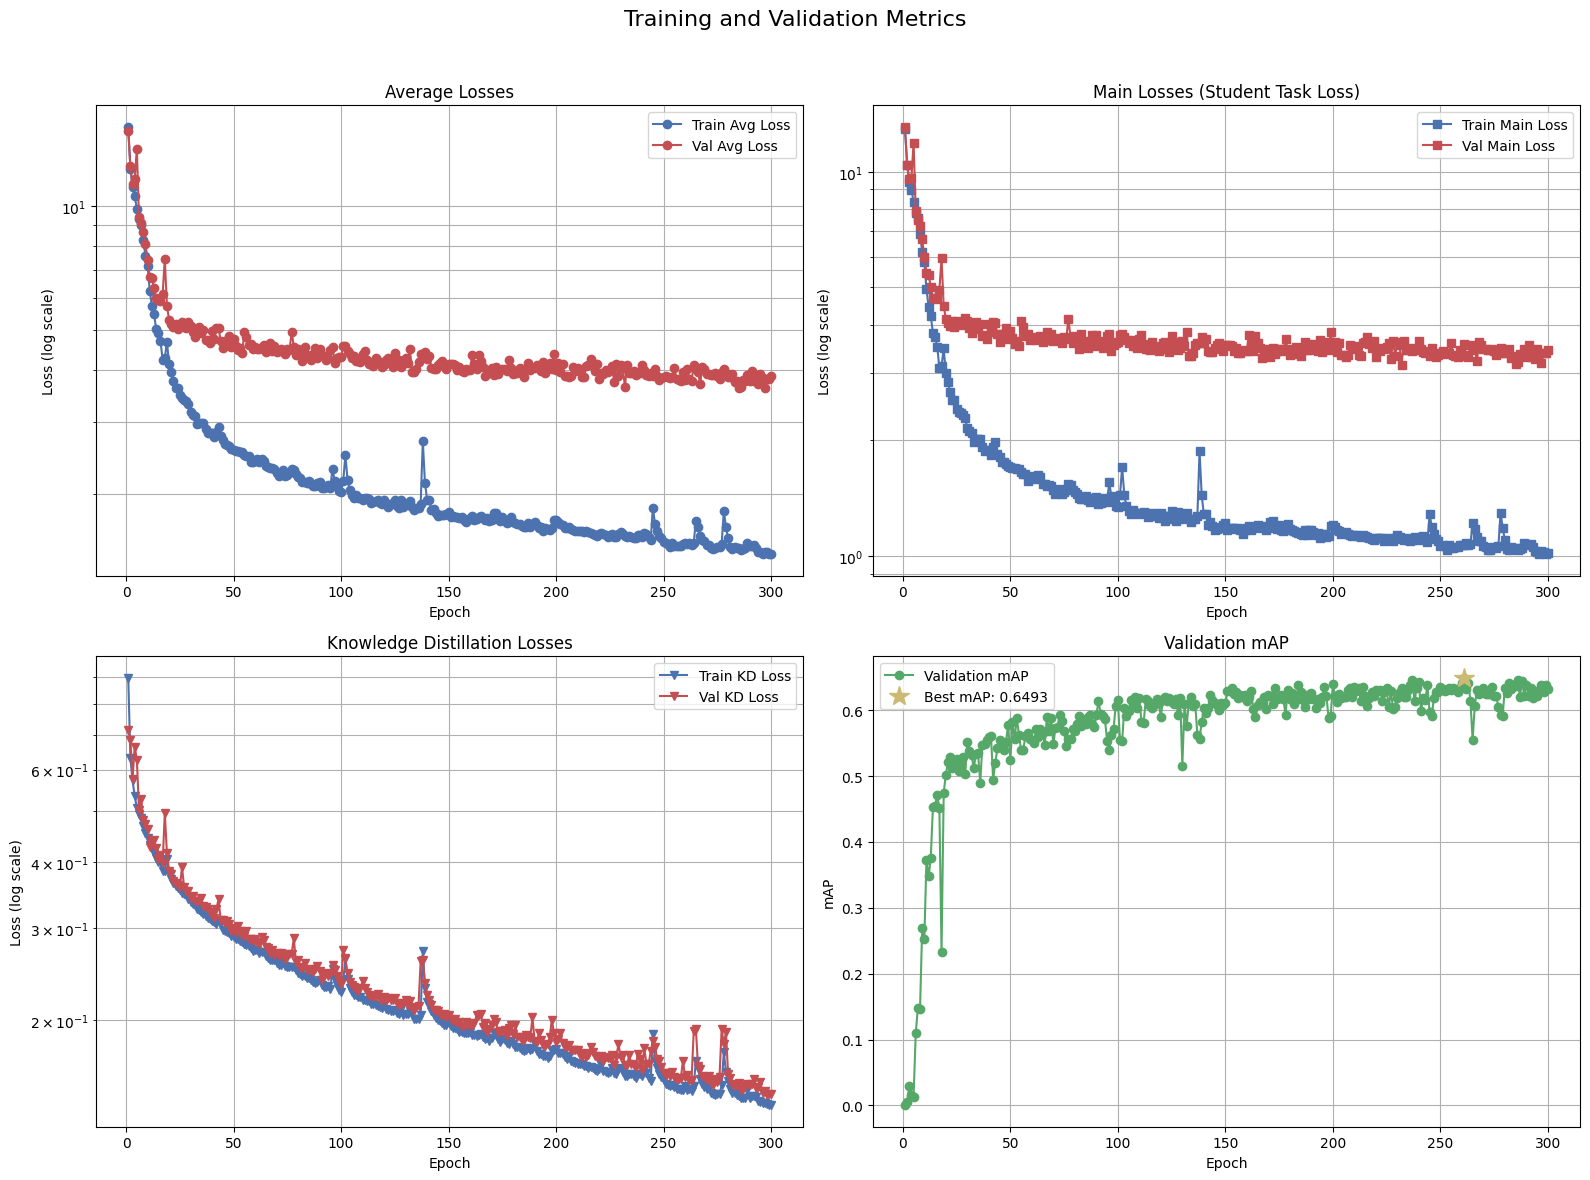

Plots saved as /kaggle/working/training_validation_metrics_log_scale.png


<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

# Tạo một range cho trục x (số epochs)
epochs_plot = range(1, num_epochs + 1)

# Tạo figure và các subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12)) # Tăng kích thước một chút
fig.suptitle('Training and Validation Metrics', fontsize=16)

# 1. Plot Average Losses
axs[0, 0].plot(epochs_plot, train_avg_losses, 'bo-', label='Train Avg Loss')
axs[0, 0].plot(epochs_plot, val_avg_losses, 'ro-', label='Val Avg Loss')
axs[0, 0].set_title('Average Losses')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss (log scale)')
axs[0, 0].set_yscale('log') # <<< ÁP DỤNG THANG ĐO LOGARIT
axs[0, 0].legend()
axs[0, 0].grid(True, which="both", ls="-") # Grid cho cả major và minor ticks

# 2. Plot Main Losses
axs[0, 1].plot(epochs_plot, train_main_losses, 'bs-', label='Train Main Loss')
axs[0, 1].plot(epochs_plot, val_main_losses, 'rs-', label='Val Main Loss')
axs[0, 1].set_title('Main Losses (Student Task Loss)')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss (log scale)')
axs[0, 1].set_yscale('log') # <<< ÁP DỤNG THANG ĐO LOGARIT
axs[0, 1].legend()
axs[0, 1].grid(True, which="both", ls="-")

# 3. Plot KD Losses
axs[1, 0].plot(epochs_plot, train_kd_losses, 'bv-', label='Train KD Loss')
axs[1, 0].plot(epochs_plot, val_kd_losses, 'rv-', label='Val KD Loss')
axs[1, 0].set_title('Knowledge Distillation Losses')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss (log scale)')
axs[1, 0].set_yscale('log') # <<< ÁP DỤNG THANG ĐO LOGARIT
axs[1, 0].legend()
axs[1, 0].grid(True, which="both", ls="-")

# 4. Plot mAP
axs[1, 1].plot(epochs_plot, maps, 'go-', label='Validation mAP')
axs[1, 1].set_title('Validation mAP')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('mAP')
# Đánh dấu epoch có mAP tốt nhất
if maps:
    best_map_value_plot = max(maps)
    # Kiểm tra xem có giá trị nào không phải là số không (ví dụ như từ epoch đầu nếu mAP chưa tính)
    valid_maps = [m for m in maps if isinstance(m, (int, float))]
    if valid_maps:
        best_map_value_plot = max(valid_maps)
        try:
            # Tìm index của best_map_value_plot trong list maps gốc
            best_epoch_idx = maps.index(best_map_value_plot)
            axs[1, 1].plot(epochs_plot[best_epoch_idx], best_map_value_plot, 'y*', markersize=15, label=f'Best mAP: {best_map_value_plot:.4f}')
        except ValueError:
            print("Warning: Best mAP value not found in the original 'maps' list for plotting marker.")

axs[1, 1].legend()
axs[1, 1].grid(True)

# Điều chỉnh layout để không bị chồng chéo
plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect để chừa chỗ cho suptitle

# Hiển thị plot
plt.show()

# Lưu biểu đồ (tùy chọn)
try:
    save_path = os.path.join(working_dir, 'training_validation_metrics_log_scale.png')
    plt.savefig(save_path)
    print(f"Plots saved as {save_path}")
except Exception as e:
    print(f"Error saving plot: {e}")

In [11]:

best_model = YOLO_lsm('LSM-YOLO/LSM-YOLO.yaml')
best_model.model.load_state_dict(torch.load('lsm_best.pt'))
best_model.val(data=data_yaml_path, split='val', project='runs', name='val')
best_model.val(data=data_yaml_path, split='test', project='runs', name='test')
""

WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       788  lsmyolo.nn.modules.RFAConv.RFAConv           [3, 16, 3, 2]                 
  1                  -1  1      6400  lsmyolo.nn.modules.RFAConv.RFAConv           [16, 32, 3, 2]                
  2                  -1  1      8736  lsmyolo.nn.modules.block.MSFM                [32, 32, 1, True]             
  3                  -1  1     19776  lsmyolo.nn.modules.block.LAE                 [32]                          
  4                  -1  2     58240  lsmyolo.nn.modules.block.MSFM                [32, 64, 2, True]             
  5                  -1  1     41600  lsmyolo.nn.modules.block.LAE                 [64]                          
  6                  -1  2    231168  lsmyolo.nn.modules.block.MSFM                [64, 128, 2, True]            
  7                  -1  1     91

''